In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from random import randint

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('../data_clean/recipes_clean.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

## Color Library

In [3]:
palette_scales = ['BrBG_r','BrBG','PRGn','PRGn_r','PiYG','PiYG_r','PuOr','PuOr_r']

palette_gradients = ['Purples','Greens','GnBu','Blues','winter_r','BuGn','BuGn_r','BuPu','BuPu_r','GnBu','GnBu_r',
                     'YlGn','YlGnBu','YlGnBu_r','YlGn_r','YlOrBr','YlOrBr_r','YlOrRd','YlOrRd_r','afmhot','afmhot_r',
                     'hot','hot_r','inferno','inferno_r','magma','magma_r','ocean','ocean_r','plasma','plasma_r',
                     'spring','spring_r','summer','summer_r','winter','winter_r']

In [4]:
colors = ['#61de2a','#029386','#04d9ff','#601ef9','#0652ff','#15b01a','#04d8b2','#6140ef','#056eee','#06b48b',
          '#12e193','#58bc08','#13eac9','#703be7','#3d7afd','#137e6d','#3f9b0b','#137e6d','#047495','#40a368',
          '#632de9','#0a888a','#0b8b87','#5d06e9','#6a79f7','#12e193','#01a049','#1fa774','#05696b','#048243',
          '#665fd1','#5539cc','#510ac9','#017b92','#18d17b','#5f34e7','#6d5acf','#01889f','#661aee','#2ee8bb',
          '#69d84f','#08787f','#6832e3','#06c2ac']

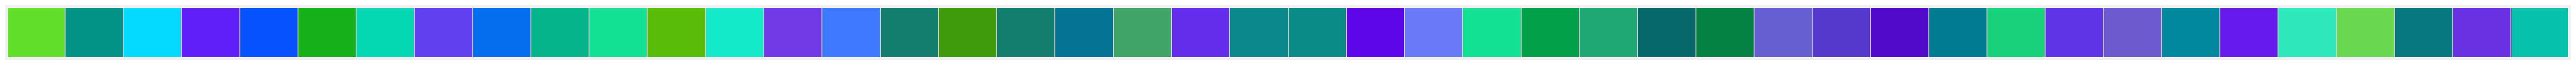

In [5]:
sns.palplot(colors)

## Table of Contents <a id='table_of_contents'></a>
- <a href='#overview'>I. Overview</a>
- <a href='#ratings'>II. Ratings (popularity)</a>
- <a href='#rating'>III. Rating (score)</a>
- <a href='#difficulty'>IV. Difficutly</a>
- <a href='#ingredients'>V. Ingredients (numuber)</a>
- <a href='#modeling'>VI. Modeling</a>
    - <a href='#linreg'>Linear Regression</a>
    - <a href='#kNN'>Logistic Regression, kNN</a>
    - <a href='#decision_tree'>Decision Tree Classifier</a>
    - <a href='#random_forest'>Random Forest</a>

# Overview <a id='overview'></a>
Examining our data from a high level, there do not appear to be many meaningful correlations. The heatmap below shows that most of our data falls in the middle of our gradient, indicating low correlation values. Many of the more highly correlated features are either implicitly correlated (e.g. Prep Time v Total Time), or are relationships we would expect to see (e.g. Number of Ingredients v Difficulty). 

To answer the question set forth in this project--What is the <i>true</i>, or projected, rating of a recipe?--we are mostly concerned with the relationship between between rating (quality) and ratings (popularity) relative to the other fields in our dataset. This is our approach for EDA in this project, examining various aspects of our data throught the lense of recipe rating and ratings.

In [6]:
df.columns

Index([u'categories', u'chef', u'difficulty', u'directions', u'ingredients',
       u'name', u'photo', u'rating', u'ratings', u'time_cook',
       u'time_inactive', u'time_prep', u'time_total', u'url', u'yield_',
       u'ingredients_num', u'difficulty_scale', u'difficulty_easy',
       u'difficulty_intermediate', u'difficulty_advanced',
       u'difficulty_expert', u'difficulty_unknown', u'photo_binary',
       u'category_1', u'category_2', u'category_3', u'category_1_num',
       u'category_2_num', u'category_3_num', u'directions_len'],
      dtype='object')

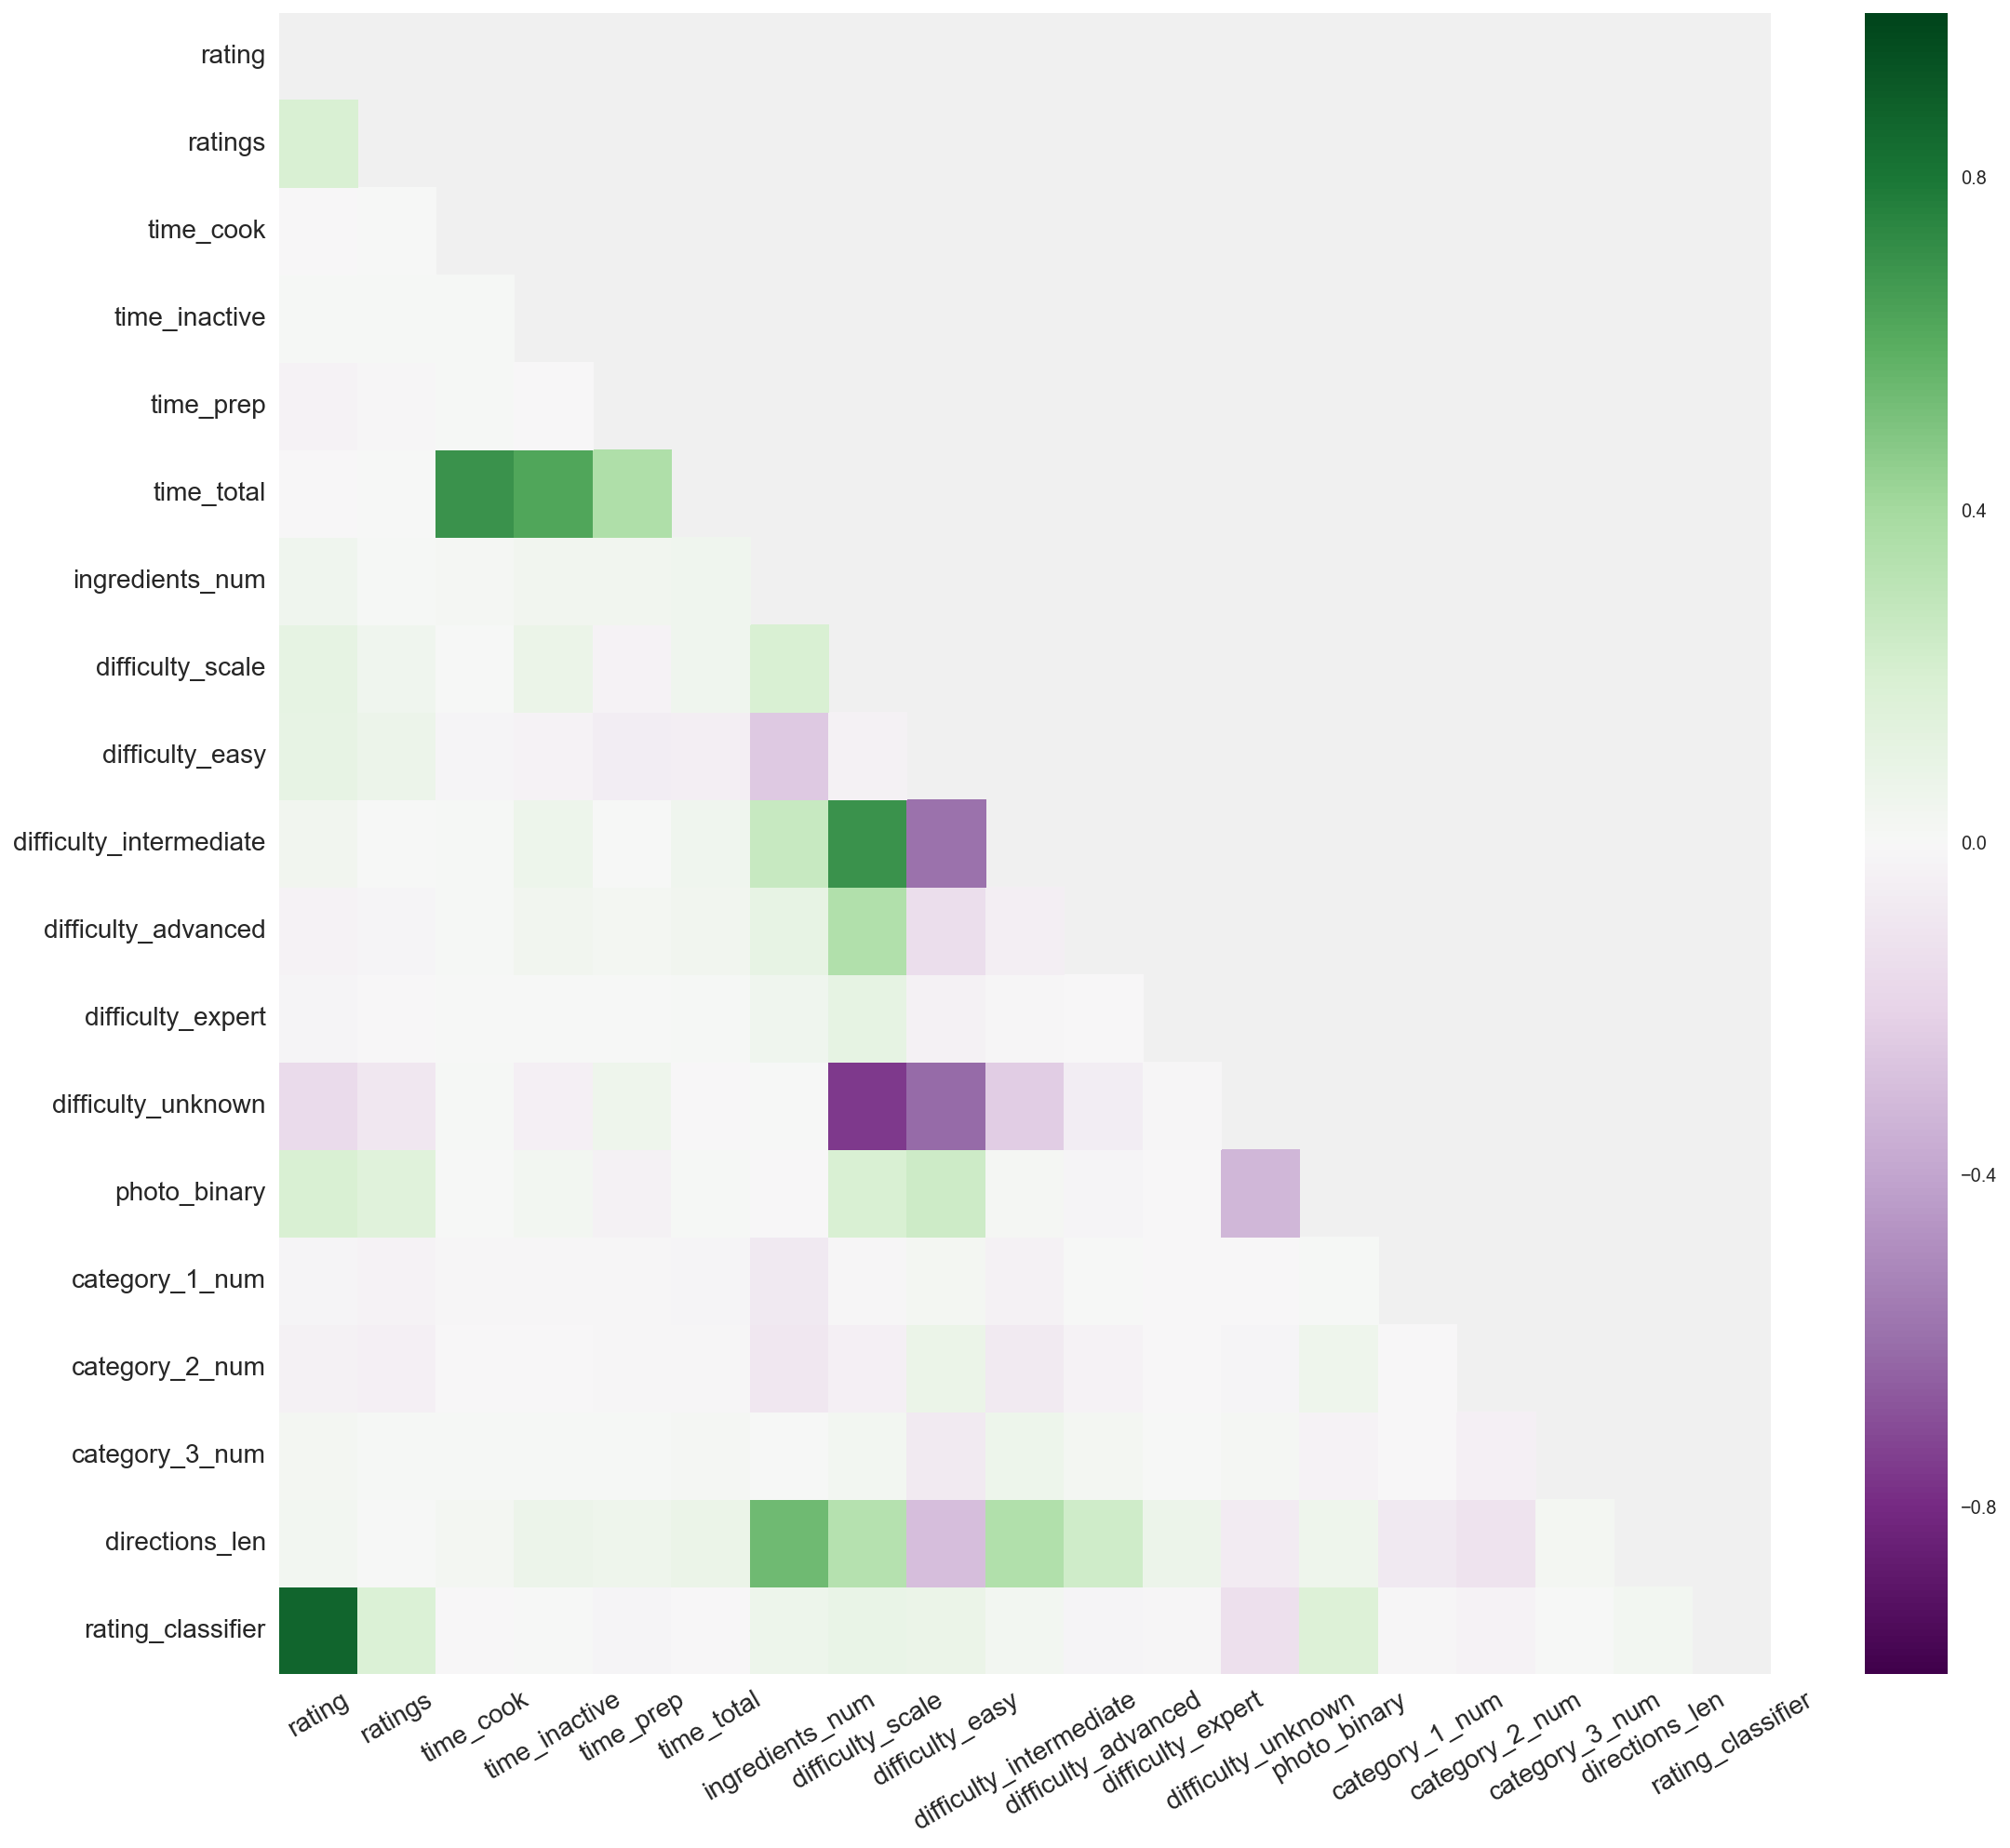

In [225]:
def heatmap(Data):
    correlations = Data.corr()
    fig, ax = plt.subplots(figsize=(16,16))
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(correlations, cmap='PRGn' ,mask=mask)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    plt.show()

heatmap(df)

In [8]:
df.describe()

,rating,ratings,time_cook,time_inactive,time_prep,time_total,ingredients_num,difficulty_scale,difficulty_easy,difficulty_intermediate,difficulty_advanced,difficulty_expert,difficulty_unknown,photo_binary,category_1_num,category_2_num,category_3_num,directions_len
count,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000,58852.000000
mean,3.250637,16.827805,45.156715,38.185516,30.327601,113.669833,11.819292,1.017739,0.614049,0.180436,0.013390,0.000663,0.191463,0.538181,110.246313,42.501325,88.632383,987.550992
std,2.088610,59.165110,398.969127,362.243855,203.347840,580.375896,6.288360,0.656593,0.486823,0.384553,0.114937,0.025734,0.393456,0.498544,90.814267,56.390682,84.159744,678.160942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,2.000000
25%,0.000000,0.000000,5.000000,0.000000,10.000000,20.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,5.000000,15.000000,523.000000
50%,4.500000,3.000000,20.000000,0.000000,15.000000,45.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,89.000000,19.000000,72.000000,854.000000
75%,5.000000,12.000000,40.000000,0.000000,25.000000,90.250000,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,163.000000,55.000000,128.000000,1273.000000
max,5.000000,5238.000000,59940.000000,30420.000000,30240.000000,59955.000000,71.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,423.000000,424.000000,424.000000,11065.000000


<a id='ratings'></a>
### <a href='#table_of_contents'>back to table of contents</a> 

# Ratings (popularity) 
Not too surprisingly, the recipes on foodnetwork.com are a lot like all the other media and things we consume--a handful of recipes are wildly popular, while the vast majority are relatively (or literally) unknown. Of the 58,852 recipes in our dataset, the ratings are skewed <b><i>heavily</i></b> right, with 75% of recipes having 12 ratings or fewer, and 26.94% have zero ratings. As the data below shows, at virtually every value for ratings, the number of recipes goes down (most visible in second row of plots, where our recipes data is subsetted for recipes with 0 < ratings <= 20).


Recipes ratings == ALL

count    58852.000000
mean        16.827805
std         59.165110
min          0.000000
25%          0.000000
50%          3.000000
75%         12.000000
max       5238.000000
Name: ratings, dtype: float64 

Recipes ratings == 0
15853 (26.94%)


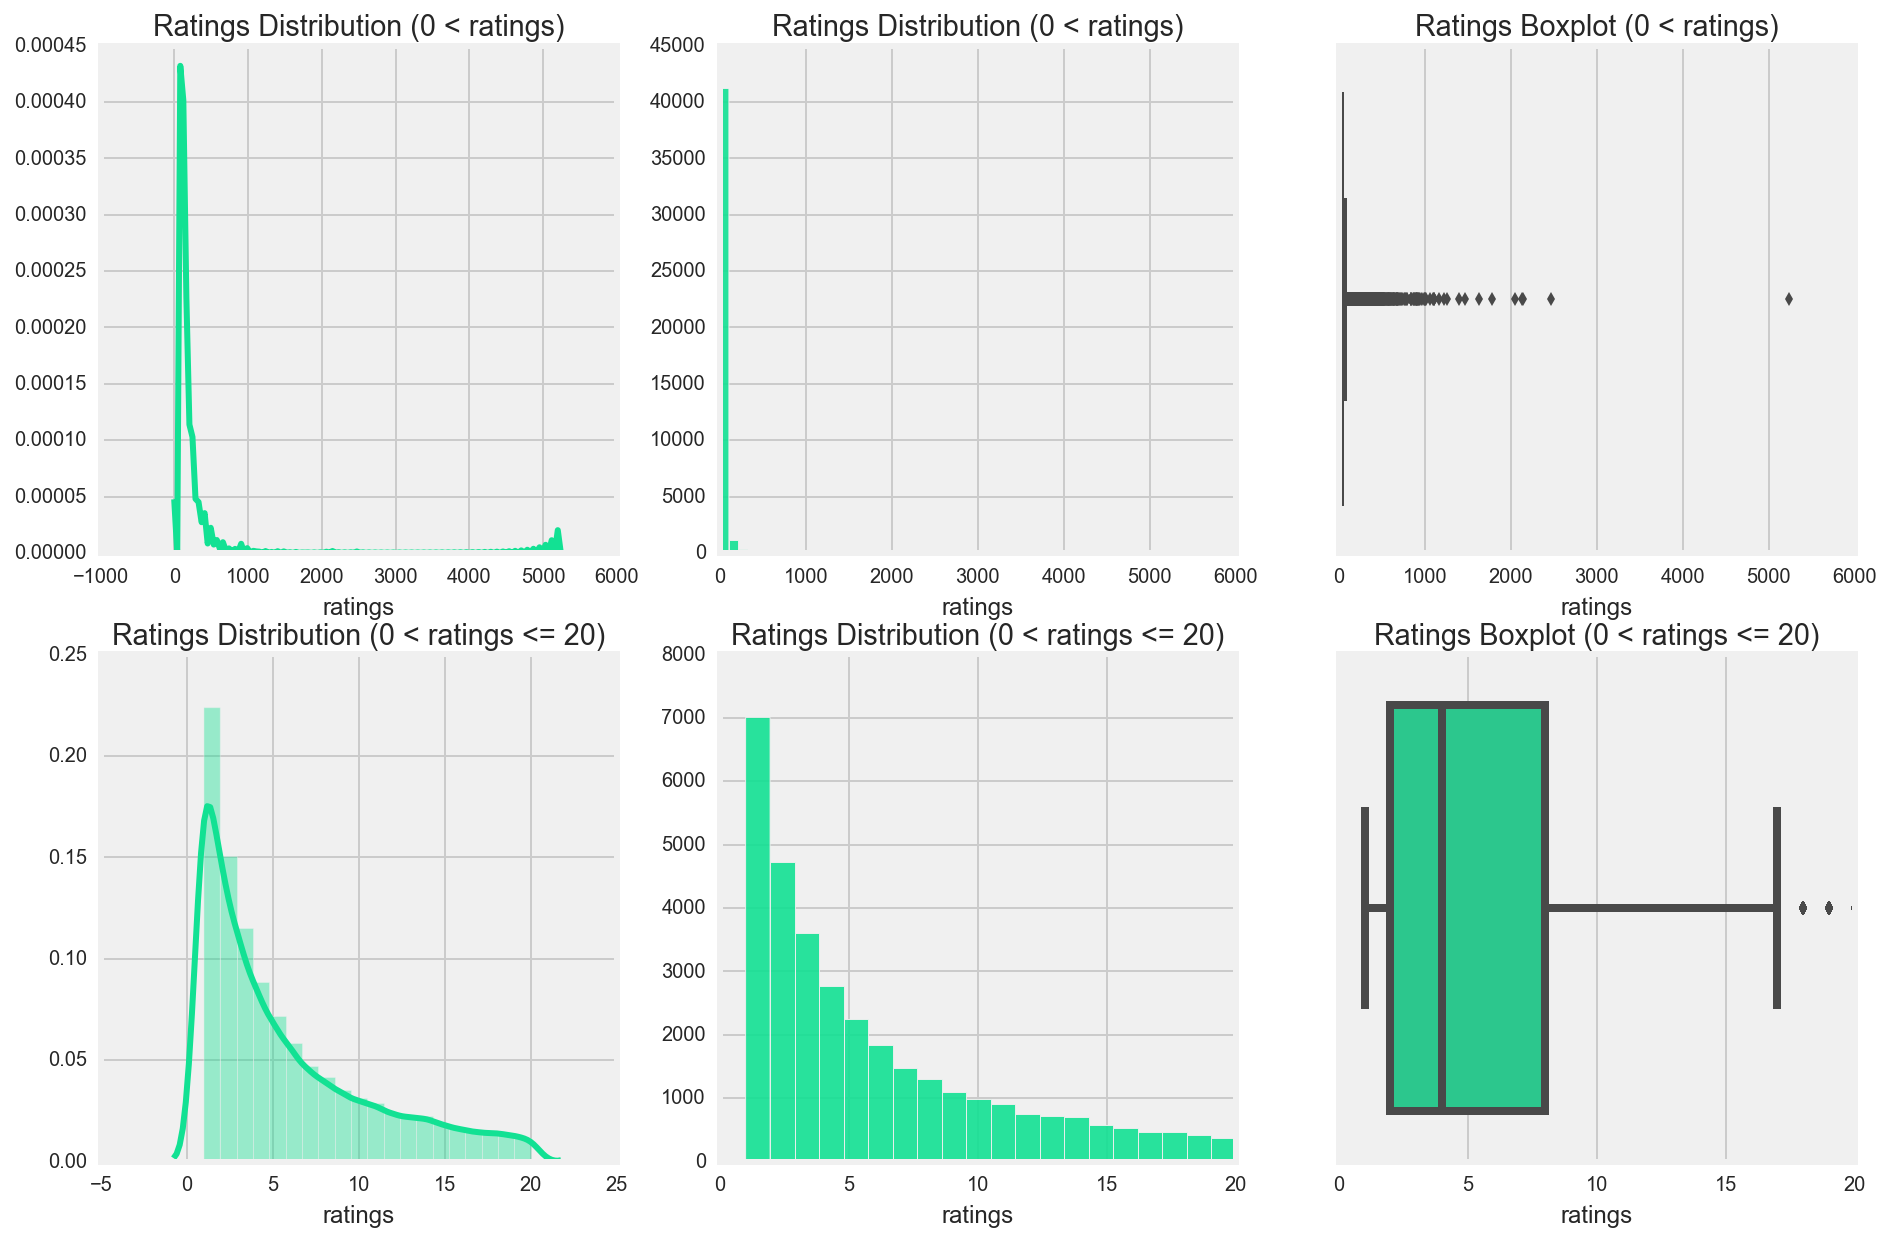

In [216]:
df_rs = df[df['ratings'] > 0]
df_0rs = df[df['ratings'] == 0]

print '\nRecipes ratings == ALL\n\n', df['ratings'].describe(), '\n'
print "Recipes ratings == 0\n", df_0rs.shape[0], \
'(%.2f%%)' % (float(df_0rs.shape[0])/df.shape[0]*100.)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,10))
random = colors[int(len(colors)*np.random.rand())]
# rating distribution
sns.distplot(df_rs.ratings, bins=None, hist=False, kde=True, kde_kws={"lw":3, 'shade':False}, 
             color=random, ax=axs[0,0])
sns.distplot(df_rs.ratings, bins=None, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[0,1])
sns.boxplot(x='ratings', data=df_rs, color=random, ax=axs[0,2])
# rating distribution for recipes with ratings > 0
sns.distplot(df_rs.ratings[df_rs.ratings <= 20], bins=20, hist=True, kde=True, kde_kws={"lw":3, 'shade':False},
             color=random, ax=axs[1,0])
sns.distplot(df_rs.ratings[df_rs.ratings <= 20], bins=20, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[1,1])
sns.boxplot(x='ratings', data=df_rs[df_rs.ratings <= 20], color=random, ax=axs[1,2])

axs[0,0].set_title('Ratings Distribution (0 < ratings)')
axs[0,1].set_title('Ratings Distribution (0 < ratings)')
axs[0,2].set_title('Ratings Boxplot (0 < ratings)')
axs[1,0].set_title("Ratings Distribution (0 < ratings <= 20)")
axs[1,1].set_title("Ratings Distribution (0 < ratings <= 20)")
axs[1,2].set_title('Ratings Boxplot (0 < ratings <= 20)')
plt.show()

The graphs below again demonstrate how heavily skewed our dataset is, showing the relationship between percentile and ratings, and vice versa. 

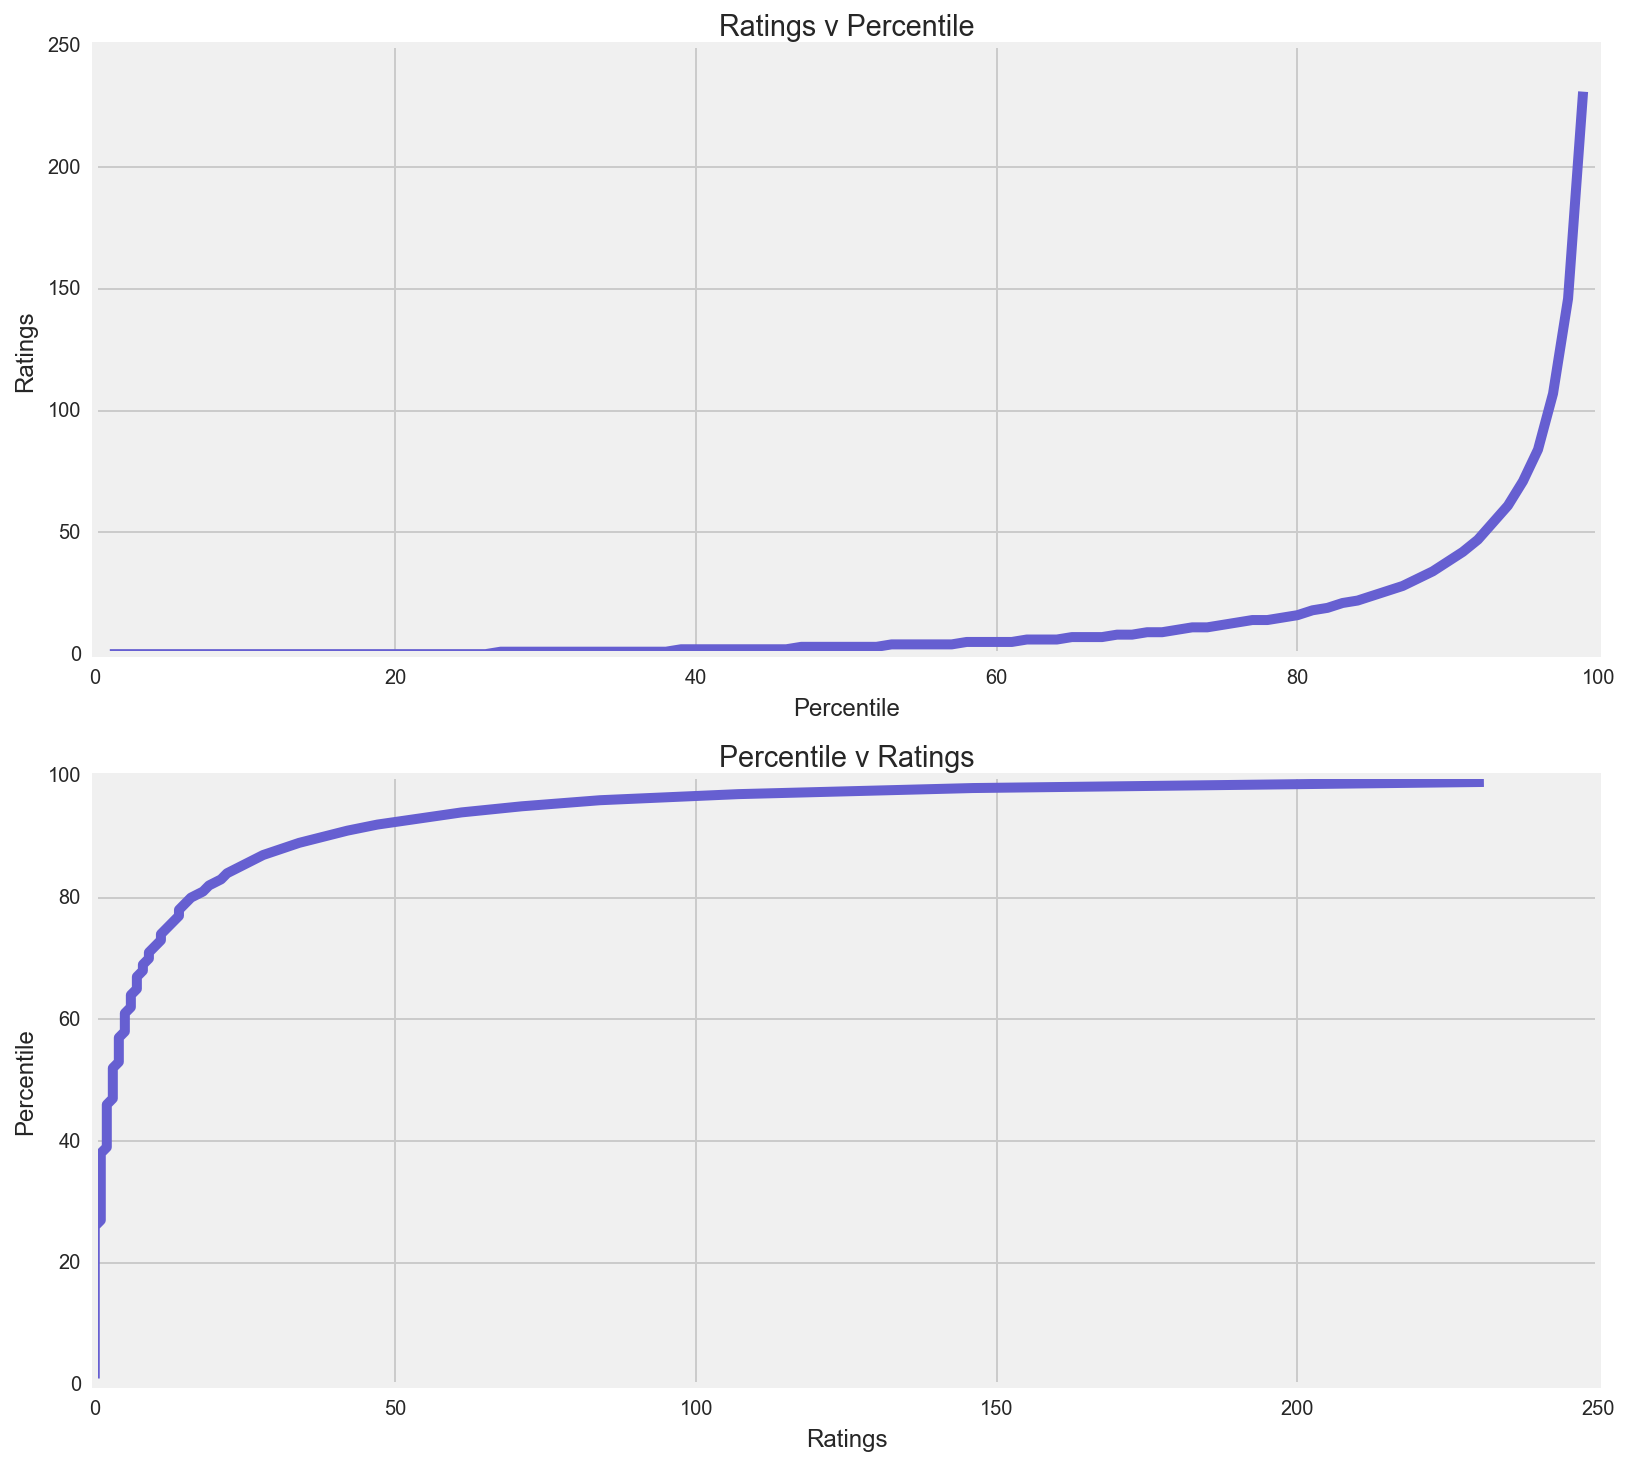

In [224]:
percentiles = range(1,100)
rating_percentiles = np.percentile(df.ratings.values, percentiles)
# random color
random = colors[int(len(colors)*np.random.rand())]
fig, ax = plt.subplots(2, figsize=(12,12))
ax[0].plot(percentiles, rating_percentiles, color=random, lw=5)
ax[0].set_xlabel('Percentile')
ax[0].set_ylabel('Ratings')
ax[0].set_title('Ratings v Percentile')
ax[1].plot(rating_percentiles, percentiles, color=random, lw=5)
ax[1].set_ylabel('Percentile')
ax[1].set_xlabel('Ratings')
ax[1].set_title('Percentile v Ratings')

plt.show()

In [81]:
print np.percentile(df.ratings.values, 75)
print stats.percentileofscore(df.ratings.values, 12)

12.0
75.0977027119


## Ratings v Rating
Not surprisingly, recipe ratings increase with recipe rating.

<i>**Excluded from the plot below are recipes with ratings==0 (it is implicit that 0 ratings recipes have a rating of 0)</i>

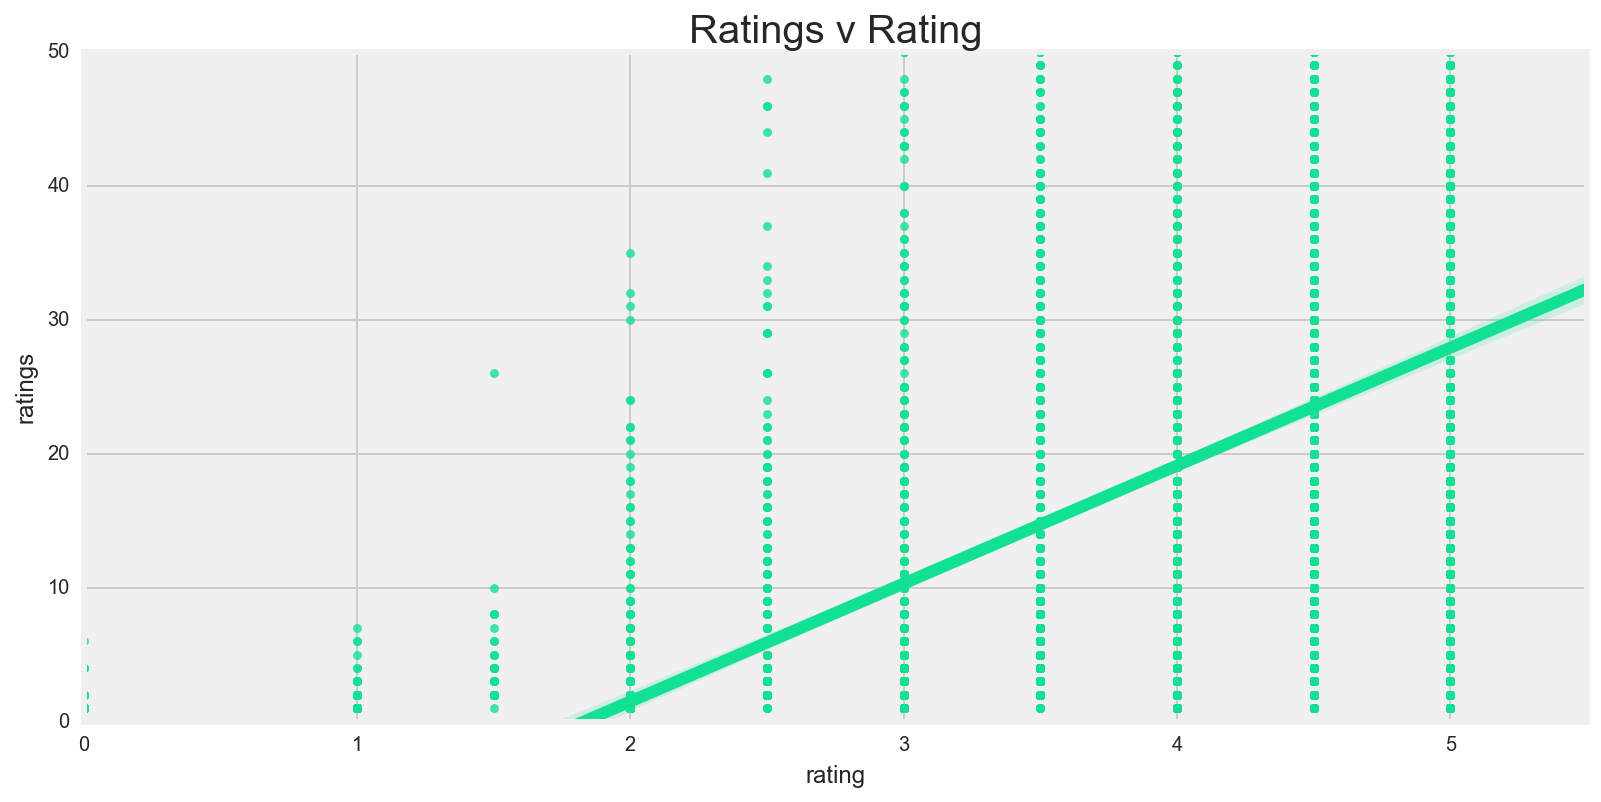

In [249]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="rating", y="ratings", data=df_rs, fit_reg=True, color=random)
ax.set_title('Ratings v Rating', fontsize=20)
ax.set_xlim([0,5.5])
ax.set_ylim([0,50])
plt.show()

## Ratings v Difficulty*
Perhaps indicative of the abundance and hype around recipes that are quick and easy (think <a href='https://www.facebook.com/buzzfeedtasty/'>Tasty</a>, or just look at the next section), the number of ratings tends to be higher for less difficult recipes.

*<i>Recipe difficulty == Unknown (difficulty_scale == 0) is treated as its own special category and thus has been left out of the regression plots shown below our distribution</i>

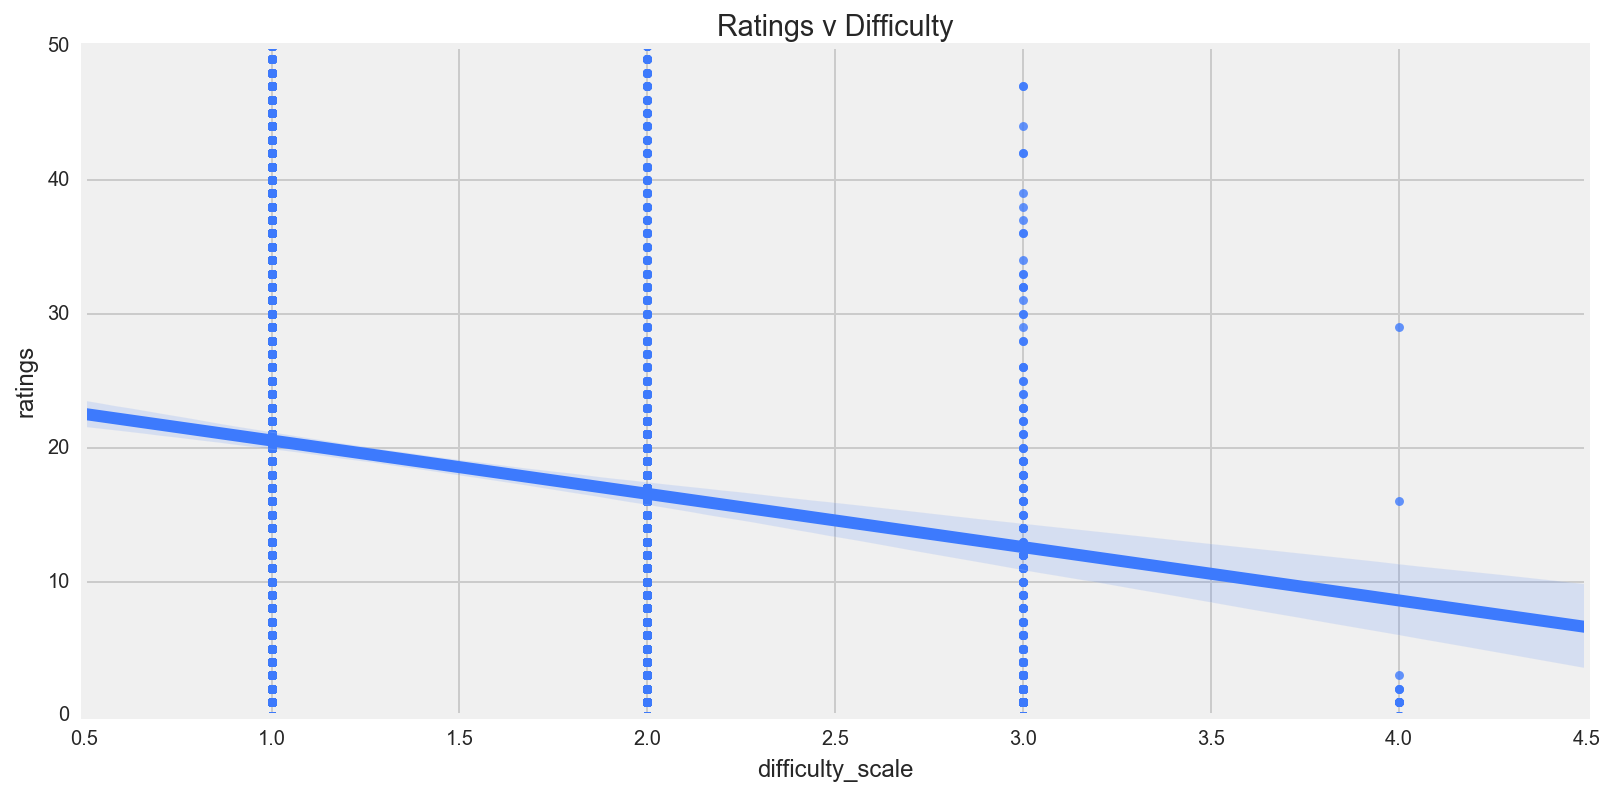

In [264]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="difficulty_scale", y="ratings", data=df[df.difficulty_scale != 0], fit_reg=True, color=random)
ax.set_title('Ratings v Difficulty')
ax.set_xlim([0.5,4.5])
ax.set_ylim([0,50])
plt.show()

### Ratings v Difficulty = Easy
As the number of ratings go up, it is fairly reliable to assume that it is an easy recipe.

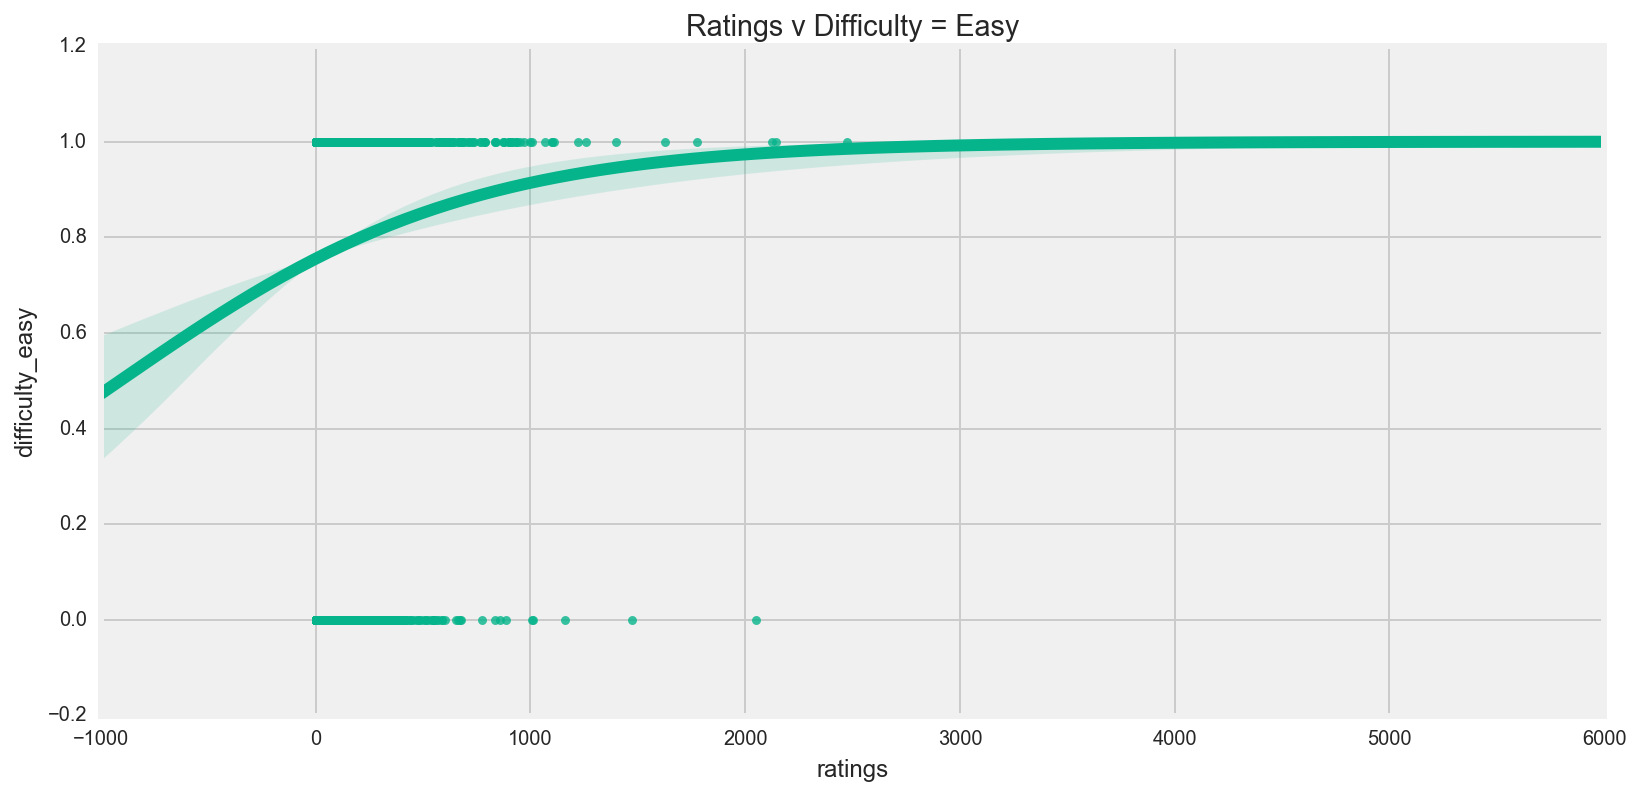

In [265]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="difficulty_easy", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Difficulty = Easy')
plt.show()

### Ratings v Difficulty = Intermediate
We start to see the shift in the difficulty scale based on ratings here, and it continues for each successive level of difficulty

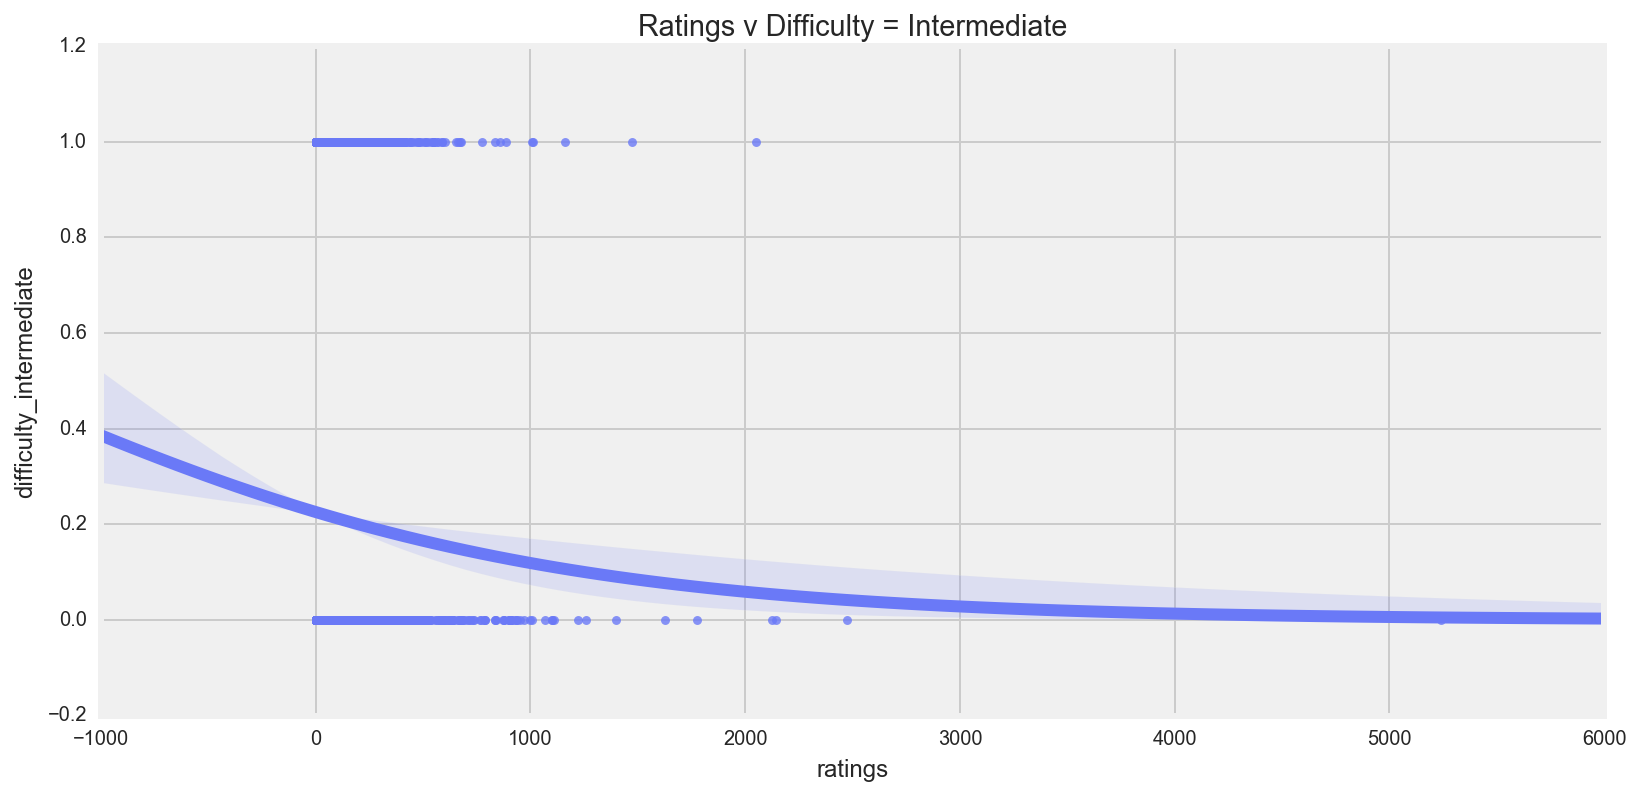

In [266]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="difficulty_intermediate", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Difficulty = Intermediate')
plt.show()

### Ratings v Difficulty = Advanced

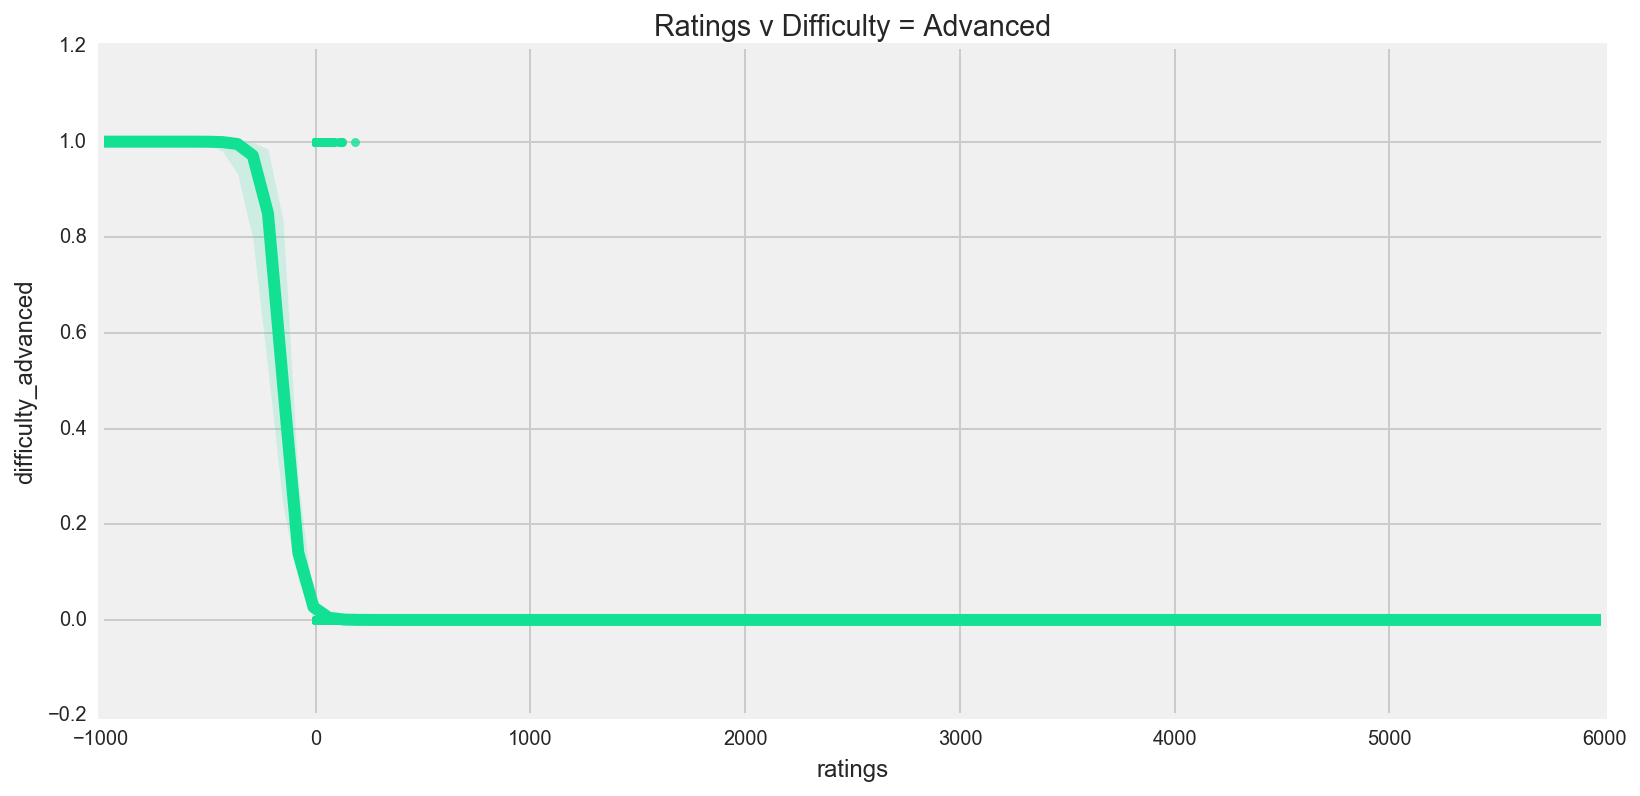

In [267]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="difficulty_advanced", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Difficulty = Advanced')
plt.show()

### Ratings v Difficulty = Expert

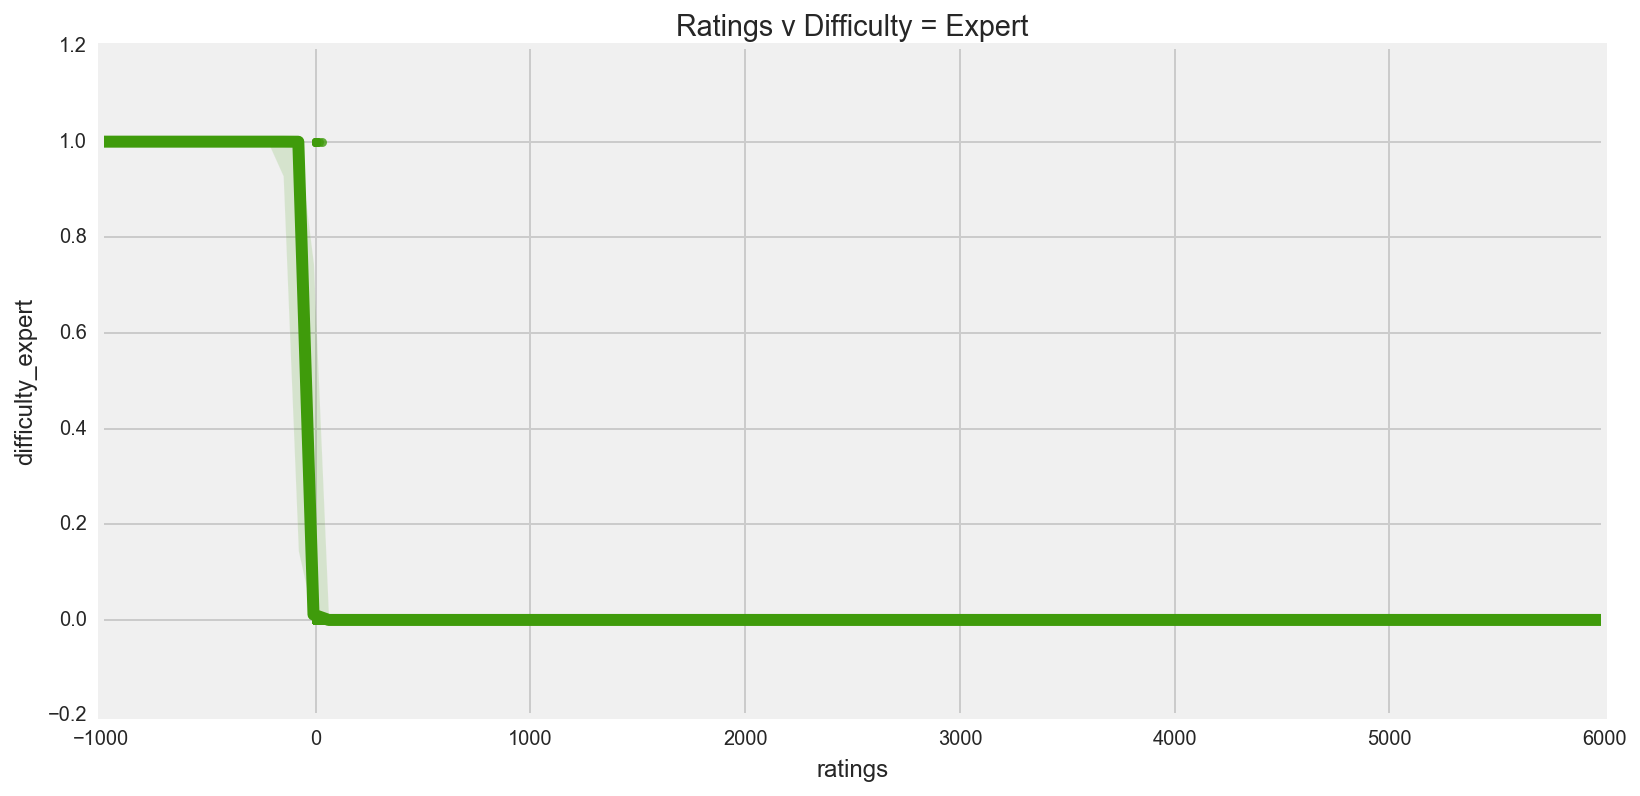

In [268]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="difficulty_expert", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Difficulty = Expert')
plt.show()

## Ratings v Photo
It is said that presentation is an important factor in how things taste--(in theory) pretty things tend to taste better. Apparently presentation is as important when deciding what to make as when eating something. Recipes with photos have much more ratings than recipes without.

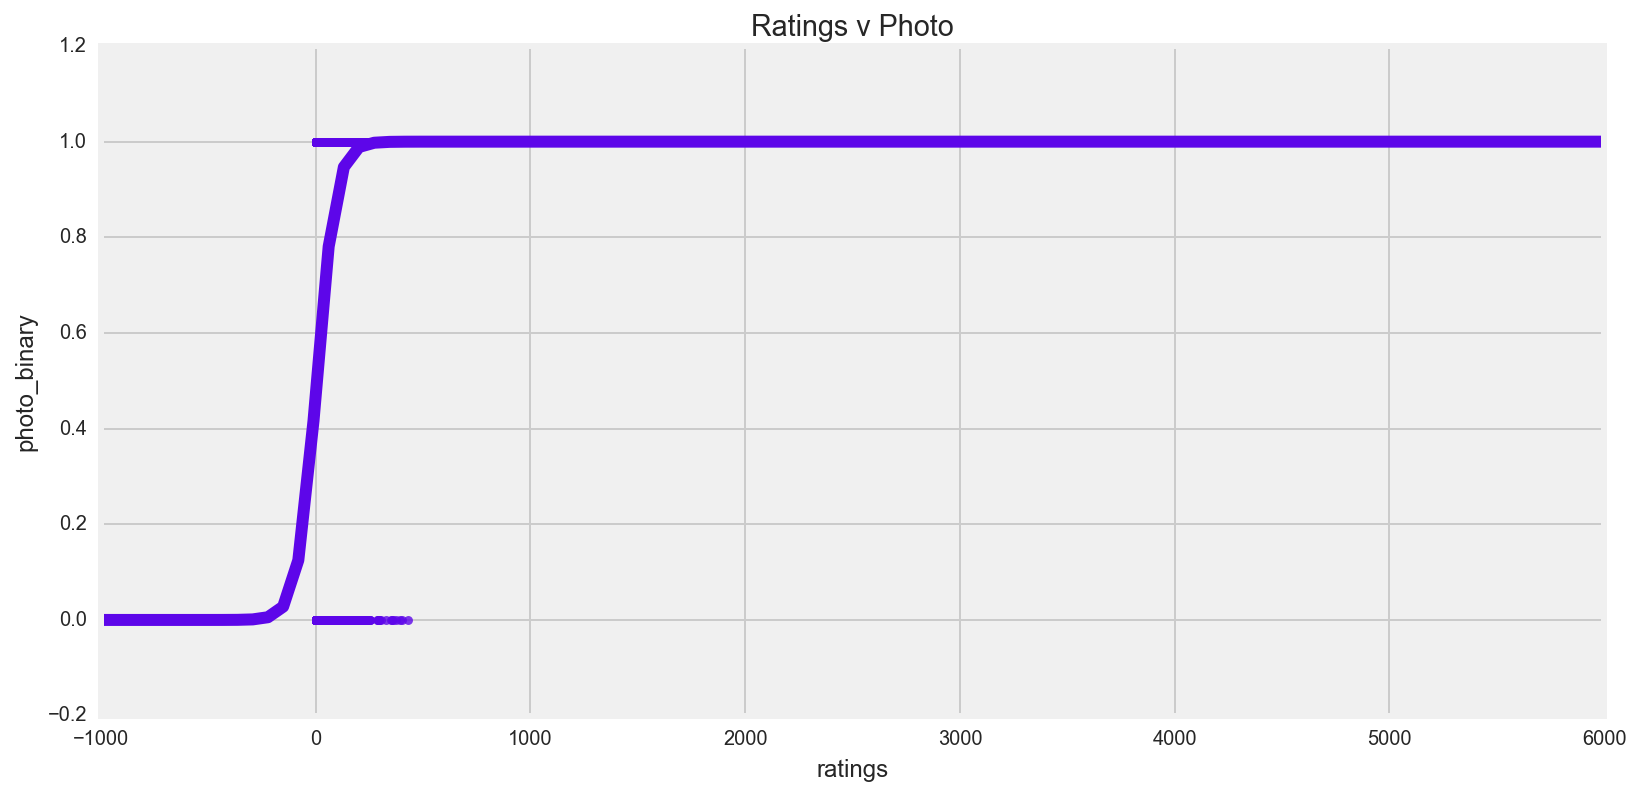

In [172]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ratings", y="photo_binary", data=df, fit_reg=True, logistic=True, color=random)
ax.set_title('Ratings v Photo')
plt.show()

## Ratings v Ingredients (number)
The number of ingredients doesn't appear to have much of an effect on the number of ratings a recipe receives, but there is a positive correlation.

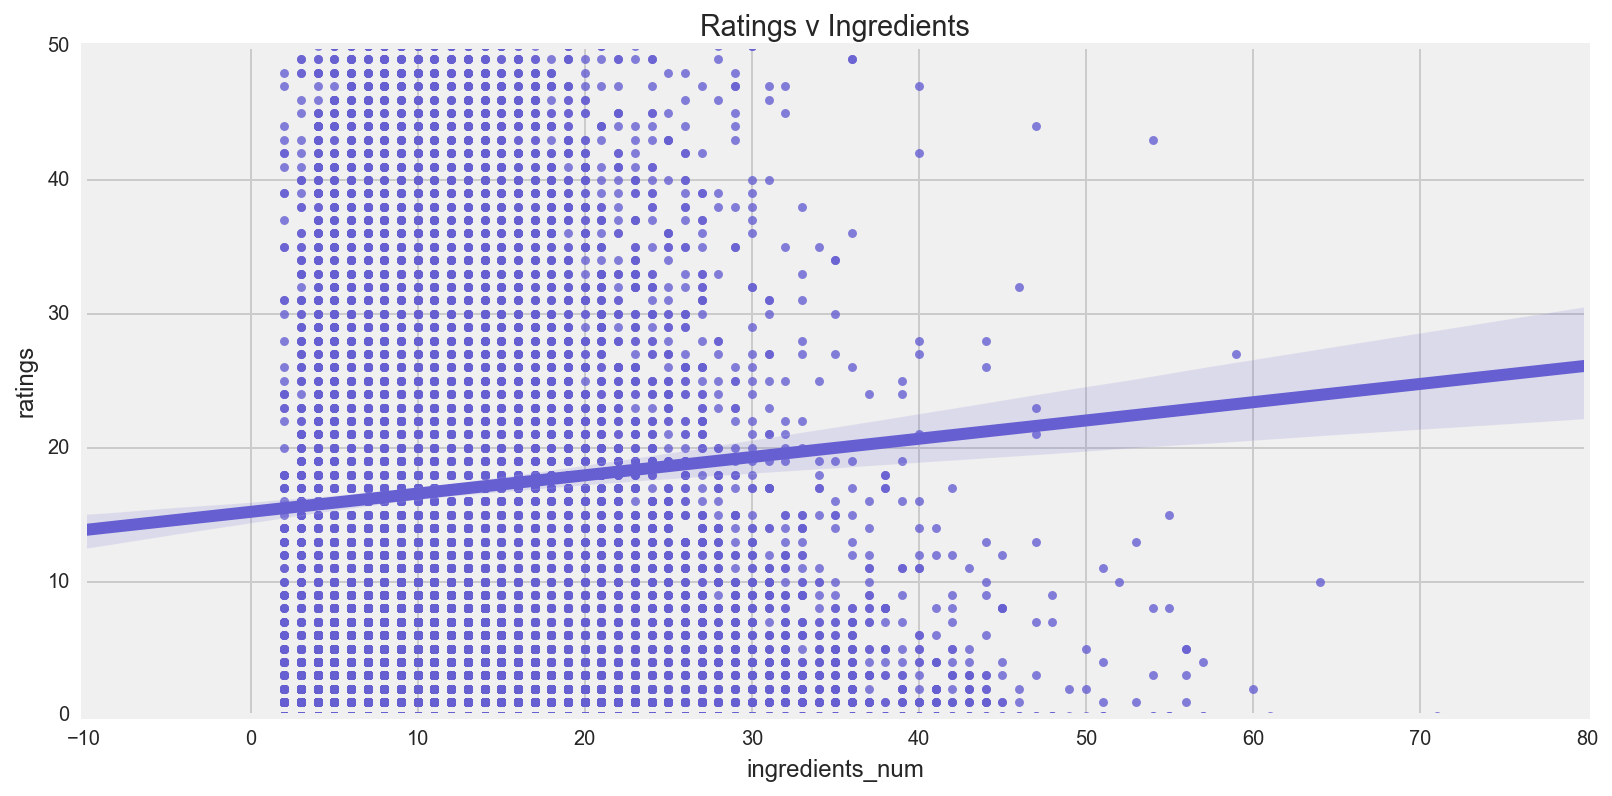

In [283]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="ratings", data=df, fit_reg=True, color=random)
ax.set_title('Ratings v Ingredients')
ax.set_ylim([0,50])
plt.show()

### The 10 most popular recipes on foodnetwork.com

In [301]:
df[['name','chef','difficulty','ratings','rating']].sort_values('ratings',ascending=False).head(10)

,name,chef,difficulty,ratings,rating
22377,GOOD EATS ROAST TURKEY,alton brown also featured in food network maga...,Easy,5238.0,5.0
2570,BAKED FRENCH TOAST CASSEROLE WITH MAPLE SYRUP,paula deen,Easy,2473.0,4.5
40831,PUMPKIN GOOEY BUTTER CAKES,paula deen,Easy,2142.0,5.0
34679,NOT YO' MAMA'S BANANA PUDDING,paula deen,Easy,2125.0,5.0
3632,BEATTY'S CHOCOLATE CAKE,barefoot contessa at home,Intermediate,2049.0,5.0
37196,PEACH COBBLER,paula deen,Easy,1777.0,4.5
13990,CORN CASSEROLE,paula deen,Easy,1627.0,5.0
29196,LASAGNA ROLLS,giada de laurentiis,Intermediate,1473.0,5.0
10146,CHICKEN PICCATA,giada de laurentiis,Easy,1397.0,5.0
34945,OLD-FASHIONED MEAT LOAF- A.K.A 'BASIC' MEAT LOAF,paula deen,Easy,1257.0,5.0


<a id='rating'></a>

### <a href='#table_of_contents'>back to table of contents</a>

# Rating (score) 
One of the first things we notice about recipe rating is how heavily weighted 0 and 5-star ratings are in our dataset.  As seen below, recipe rating, like recipe ratings has a a heavily skewed distribution. One of the main problems we see with the rating system is that a recipe with 1 5-star rating is objectively equivalent to a recipe with 10 5-star ratings, and objectively better than a recipe with 100 4-star ratings. Furthermore, the recipes on foodnetwork.com are eith very well curated or the users are easy to please--by far, the most common rating given by users is a 5.0. At first glance, it appears that 0 is the second highest rating, but when we subset for recipes with 1 or more ratings, we find that nearly all the 0 rated recipes were ones with 0 ratings.

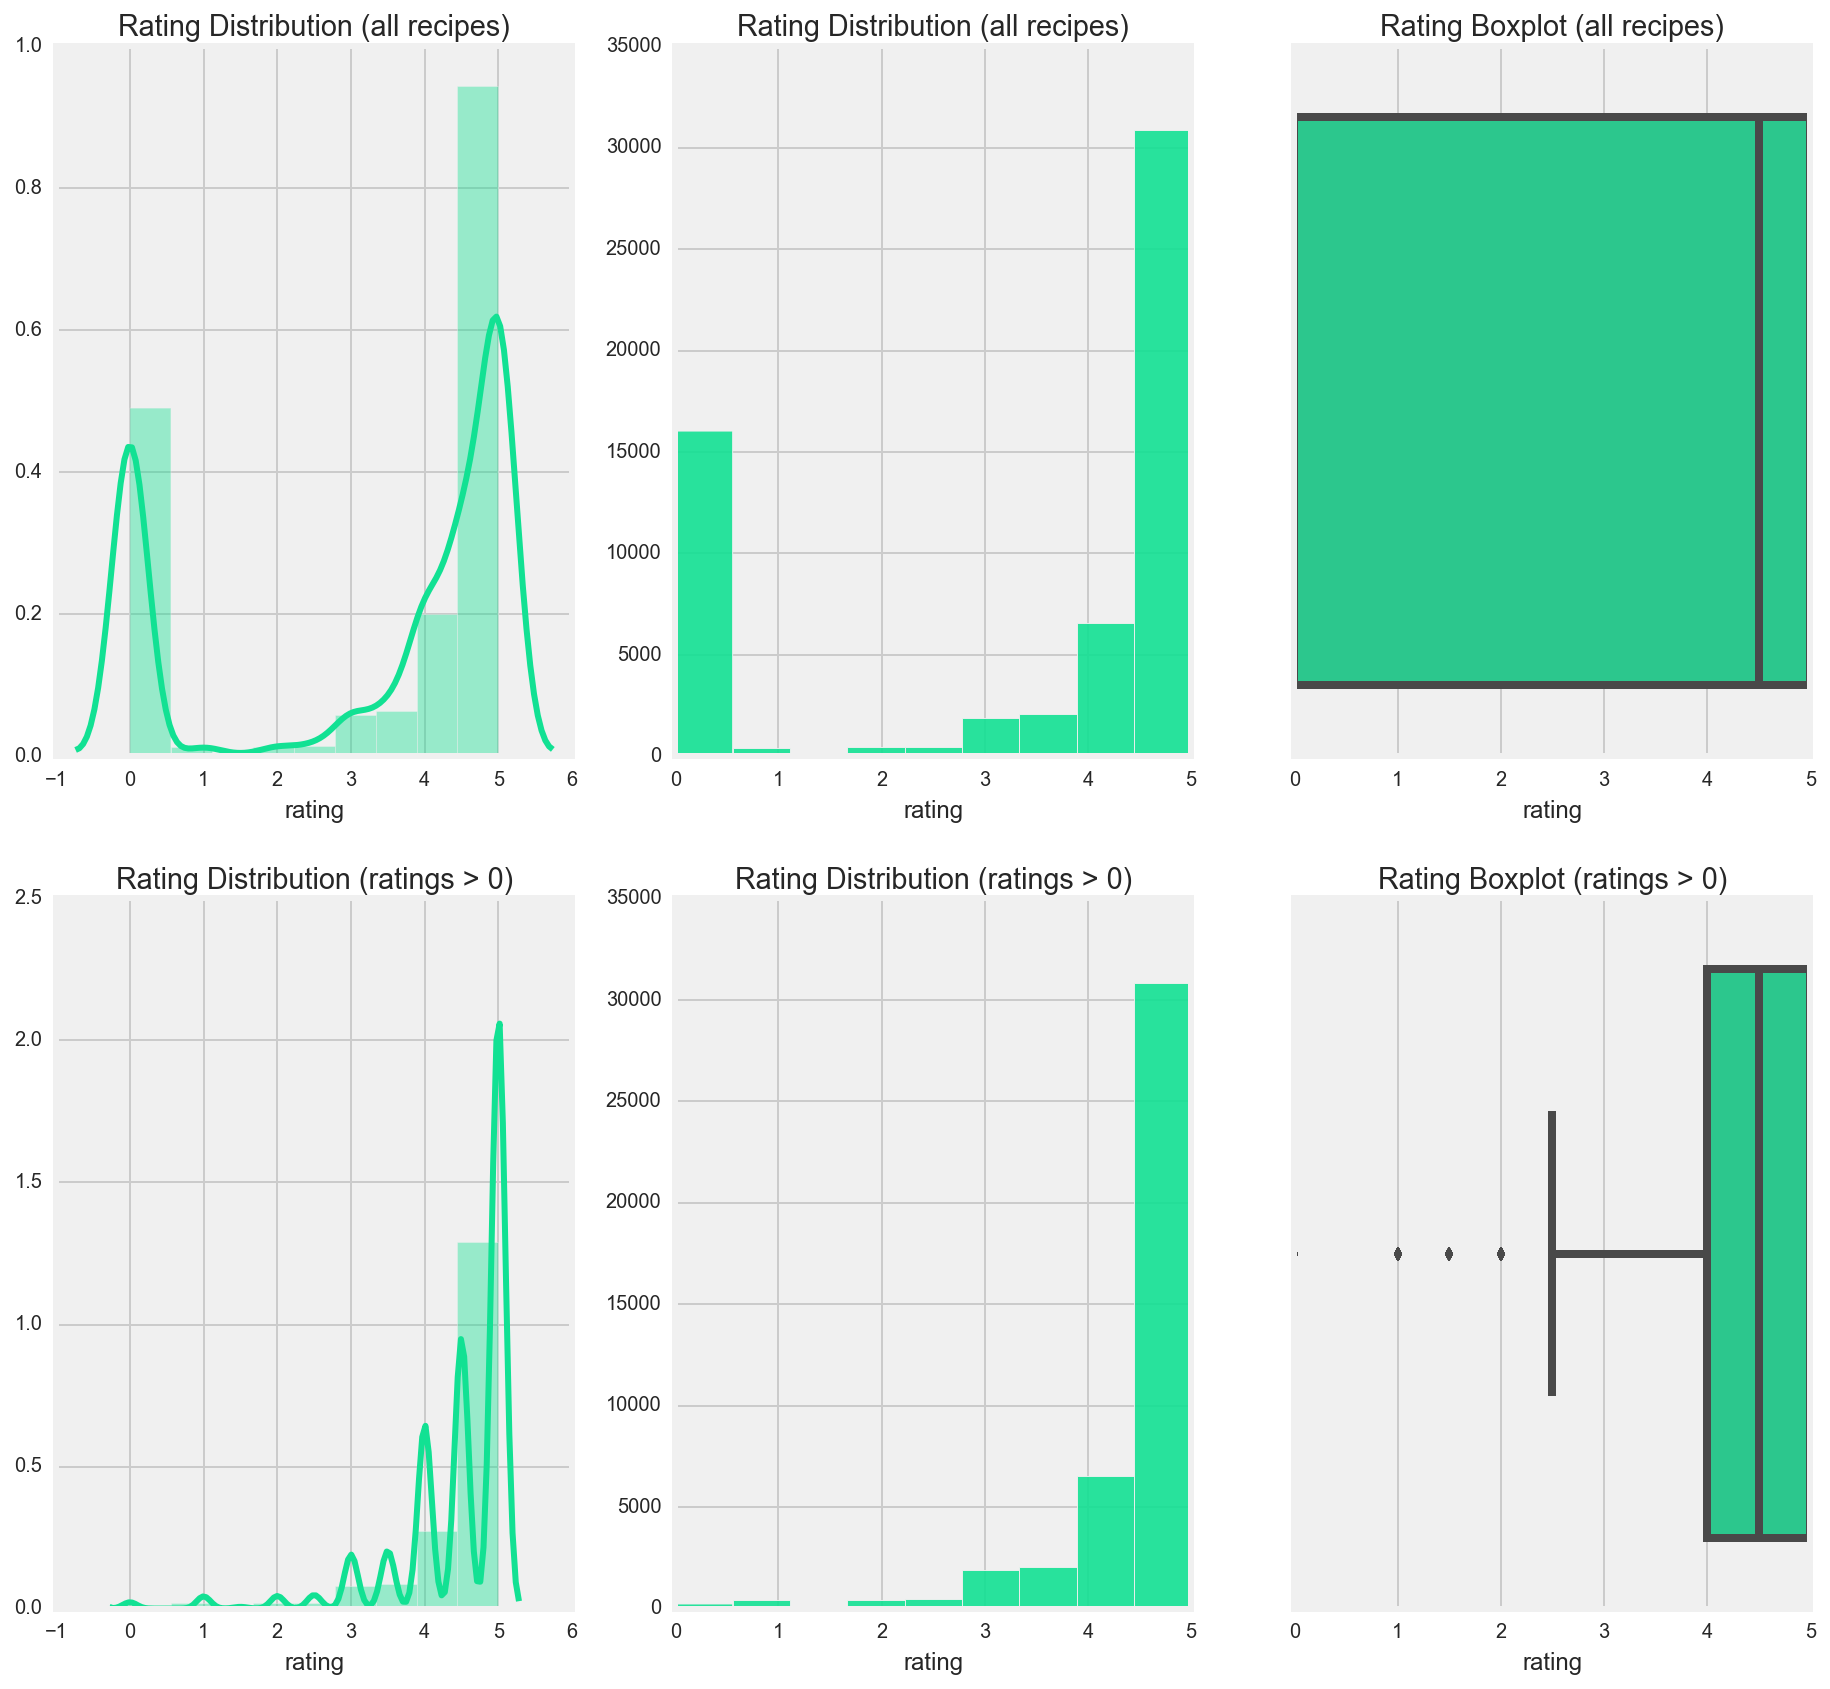

In [199]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,14))
random = colors[int(len(colors)*np.random.rand())]
# rating distribution
sns.distplot(df.rating, bins=9, hist=True, kde=True, kde_kws={"lw":3, 'shade':False}, 
             color=random, ax=axs[0,0])
sns.distplot(df.rating, bins=9, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[0,1])
sns.boxplot(x='rating', data=df, color=random, ax=axs[0,2])
# rating distribution for recipes with ratings > 0
sns.distplot(df_rs.rating, bins=9, hist=True, kde=True, kde_kws={"lw":3, 'shade':False},
             color=random, ax=axs[1,0])
sns.distplot(df_rs.rating, bins=9, hist=True, kde=False, hist_kws={'alpha':.9}, 
             color=random, ax=axs[1,1])
sns.boxplot(x='rating', data=df_rs, color=random, ax=axs[1,2])

axs[0,0].set_title('Rating Distribution (all recipes)')
axs[0,1].set_title('Rating Distribution (all recipes)')
axs[0,2].set_title('Rating Boxplot (all recipes)')
axs[1,0].set_title("Rating Distribution (ratings > 0)")
axs[1,1].set_title("Rating Distribution (ratings > 0)")
axs[1,2].set_title('Rating Boxplot (ratings > 0)')
plt.show()

### The 10 worst recipes on foodnetwork.com
Yes, a handful of recipes received 0-star ratings. What a shame and surprise that Mom's Spaghetti & Meatballs is literally the worst.

In [300]:
df[['name','chef','difficulty','ratings','rating']]\
[(df.ratings > 0) & (df.rating==0)].sort_values('ratings',ascending=False).head(10)

,name,chef,difficulty,ratings,rating
33382,MOM'S SPAGHETTI AND MEATBALLS,"adapted ""one dish at a time: delicious s my ...",Easy,6.0,0.0
33214,MOCHA POPS,food network kitchen,Easy,4.0,0.0
51648,STUFFED BLOODY MARY,geoffrey zakarian,Easy,4.0,0.0
48427,S'MORES DIP,food network kitchen,Easy,4.0,0.0
38764,PISTACHIO-COATED CHEESE LOG,patricia heaton parties,Easy,2.0,0.0
11345,CHOCOLATE CHIP COOKIE DOUGH TRUFFLES,food network kitchen,Easy,2.0,0.0
37937,PEPPERMINT CREAMS,lorraine pascale,Unknown,2.0,0.0
52322,SUNNY'S QUICK CHEESE PUFF SQUARES,sunny anderson,Easy,2.0,0.0
38652,PINK LEMONADE SHOTS,victoria belanger,Easy,2.0,0.0
9125,CHEESY MASHED POTATOES,nancy fuller,Easy,2.0,0.0


## Rating v Difficulty
When comparing rating distributions by difficulty level, there is almost no variance between them, suggesting that recipe rating is independent of difficulty level.

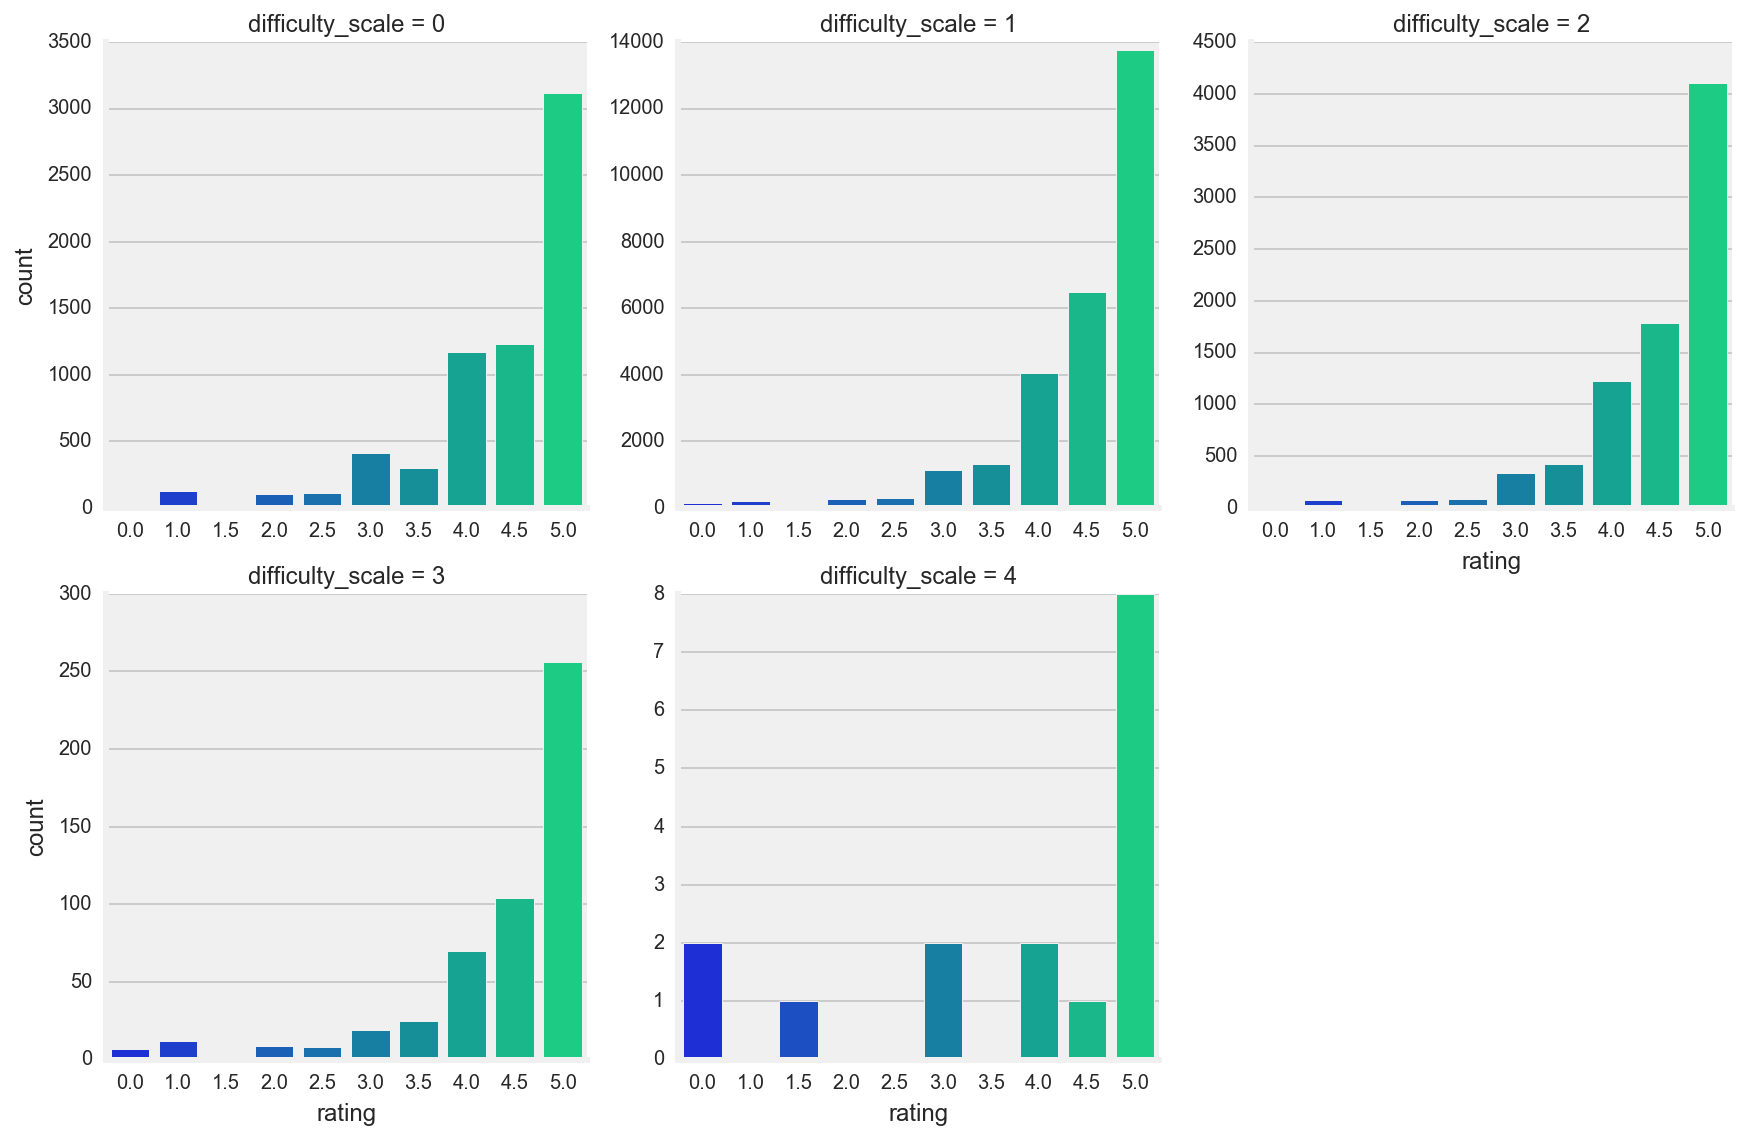

In [277]:
sns.factorplot(x="rating", data=df_rs, kind="count", palette="winter", col='difficulty_scale', col_wrap=3,
               sharex=False, sharey=False)
plt.show()

## Rating v Photo
As the logistic regression below suggests, recipes with a photo tend to recieve a higher rating. 

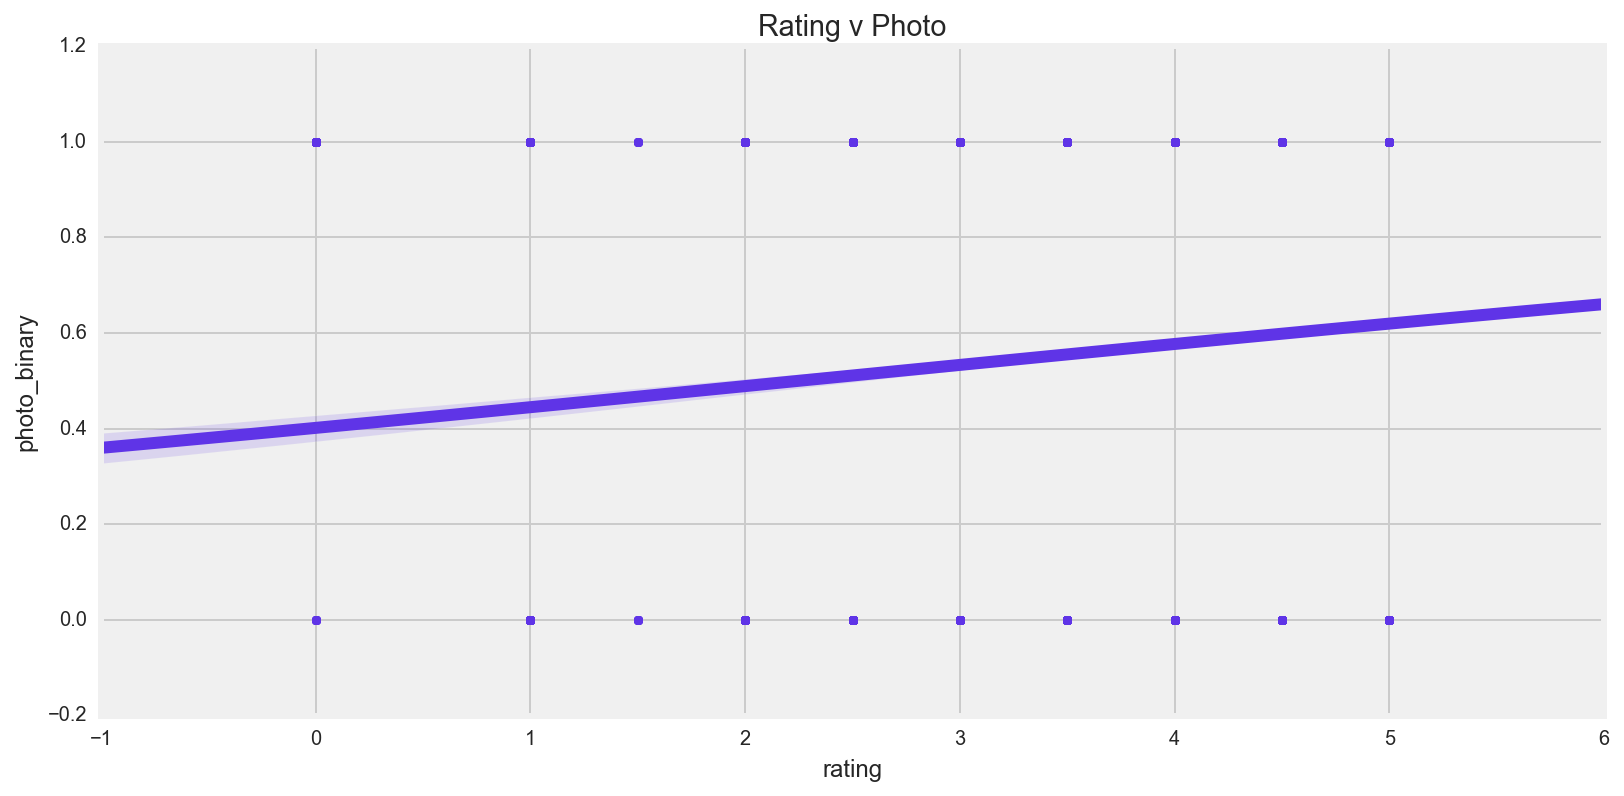

In [279]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="rating", y="photo_binary", data=df_rs, fit_reg=True, logistic=True, color=random)
ax.set_title('Rating v Photo')
plt.show()

<a id='difficulty'></a>
### <a href='#table_of_contents'>back to table of contents</a>

# Difficulty*

*<i>Recipe difficulty == Unknown (difficulty_scale == 0) is treated as its own special category</i>

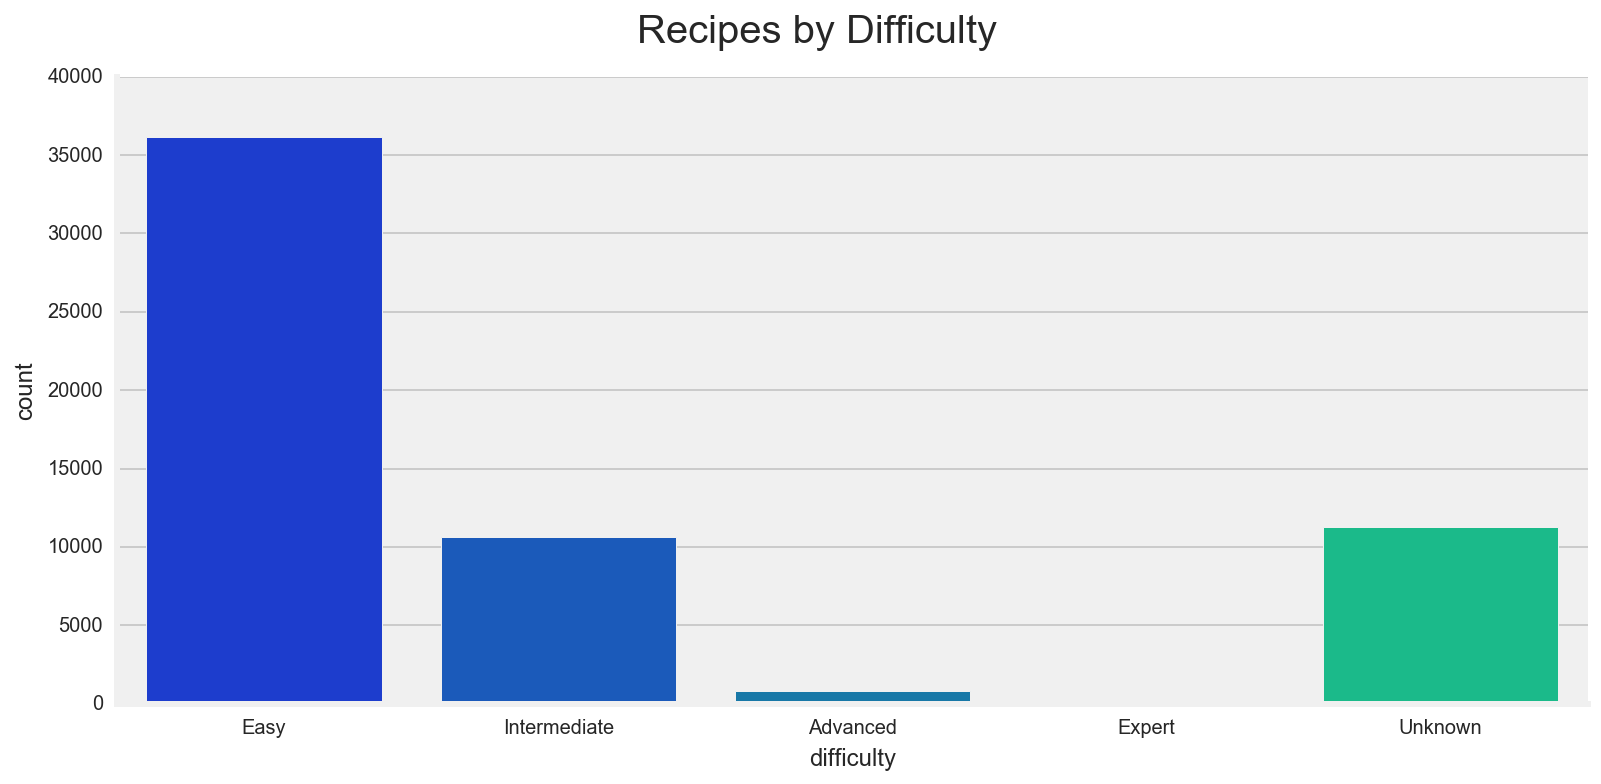

In [262]:
g = sns.factorplot(x="difficulty", data=df, kind="count", palette="winter", size=5.5, aspect=2, 
                   order=['Easy','Intermediate','Advanced','Expert','Unknown'])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Recipes by Difficulty', fontsize=20)
plt.show()

## Difficulty v Ingredients (number)
A fairly straightforward finding, difficulty increases with the number of ingredients in a recipe.

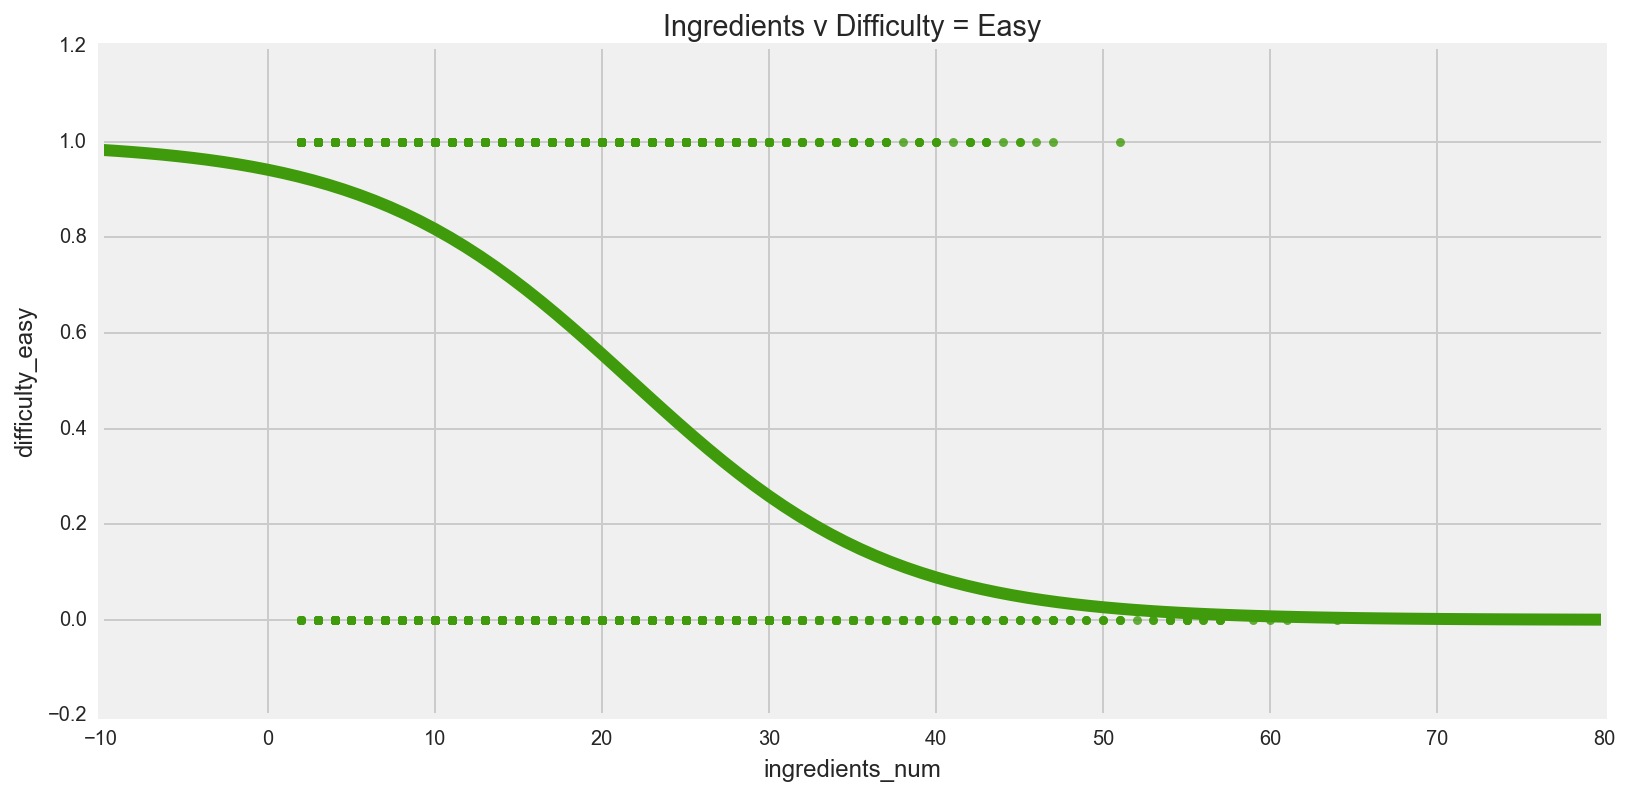

In [286]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="difficulty_easy", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ingredients v Difficulty = Easy')
plt.show()

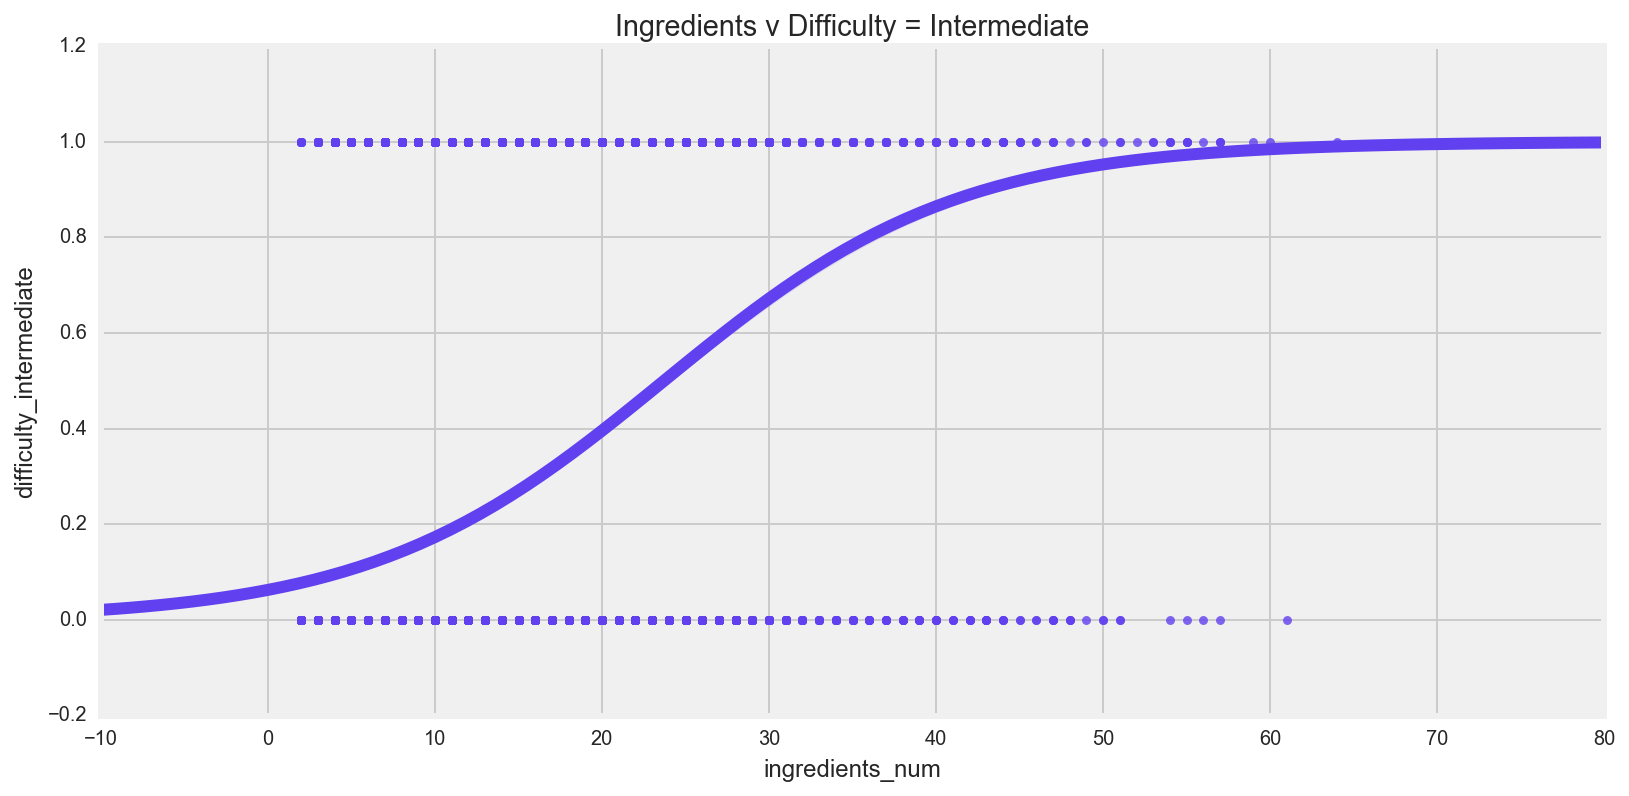

In [287]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="difficulty_intermediate", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ingredients v Difficulty = Intermediate')
plt.show()

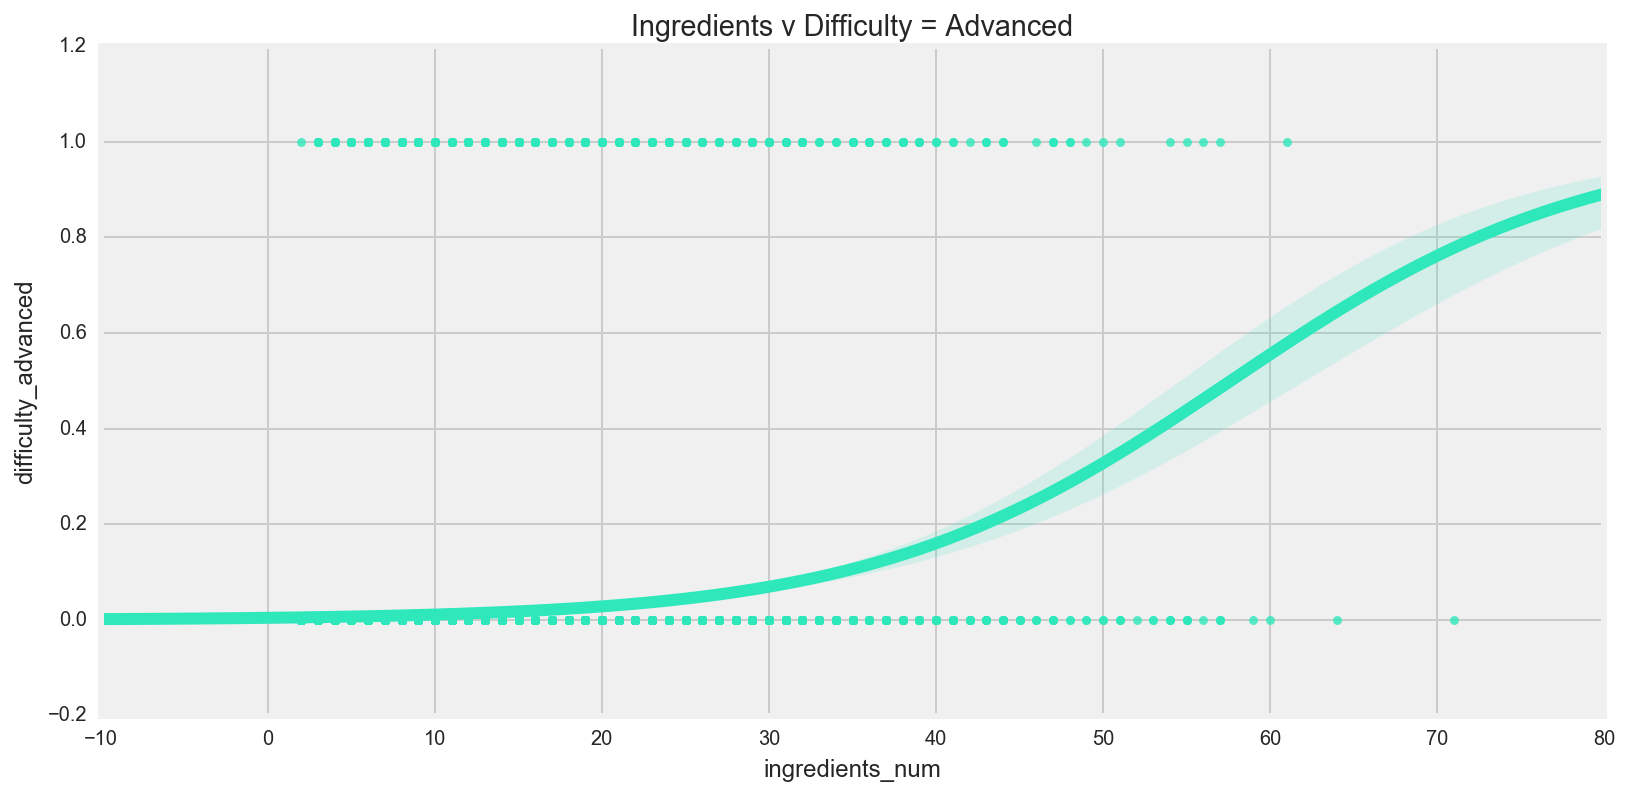

In [288]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="difficulty_advanced", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ingredients v Difficulty = Advanced')
plt.show()

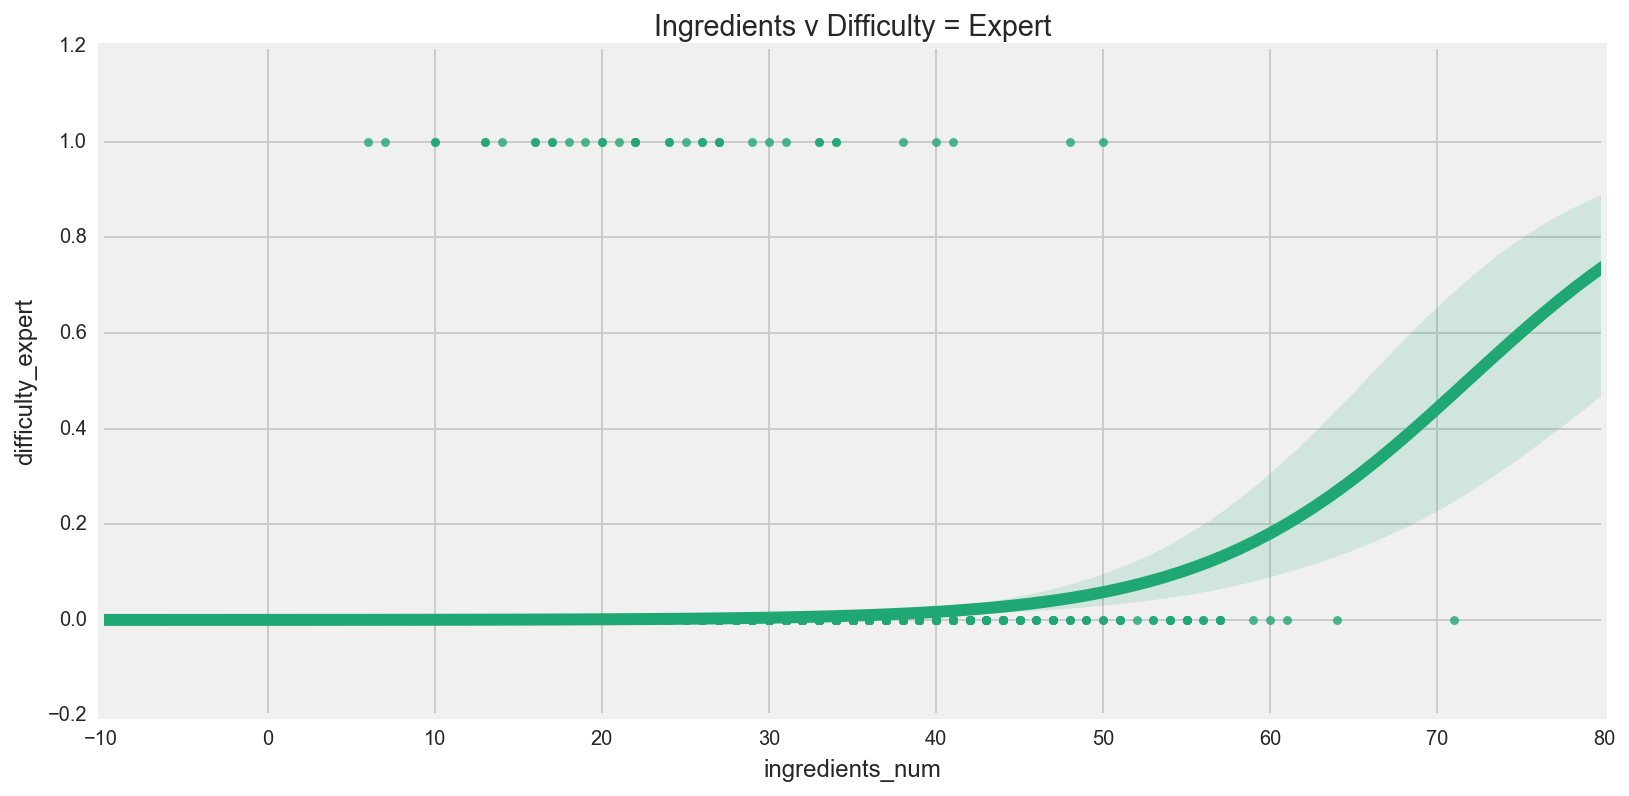

In [289]:
fig = plt.figure(figsize=(12,6))
ax = fig.gca()
# random color
random = colors[int(len(colors)*np.random.rand())]
ax = sns.regplot(x="ingredients_num", y="difficulty_expert", data=df[df.difficulty_scale != 0], 
                 fit_reg=True, logistic=True, color=random)
ax.set_title('Ingredients v Difficulty = Expert')
plt.show()

<a id='ingredients'></a>
### <a href='#table_of_contents'>back to table of contents</a>

# Ingredients (number) 

Doing a quick overview of the ingredients category, we find a fairly normal distribution of ingredients, skewed slightly right. The most frequent number of ingredients in a recipe is 9 with 4,633 recipes, while 75% of recipes have 15 or fewer ingredients. The results are not too surprising here, it makes sense that the majority of recipes would have fewer ingredients. Below you can see the top 10 recipes with the most ingredients.


Mode: 9 ingredients - 4633 recipes 

count    58852.000000
mean        11.819292
std          6.288360
min          2.000000
25%          7.000000
50%         11.000000
75%         15.000000
max         71.000000
Name: ingredients_num, dtype: float64 



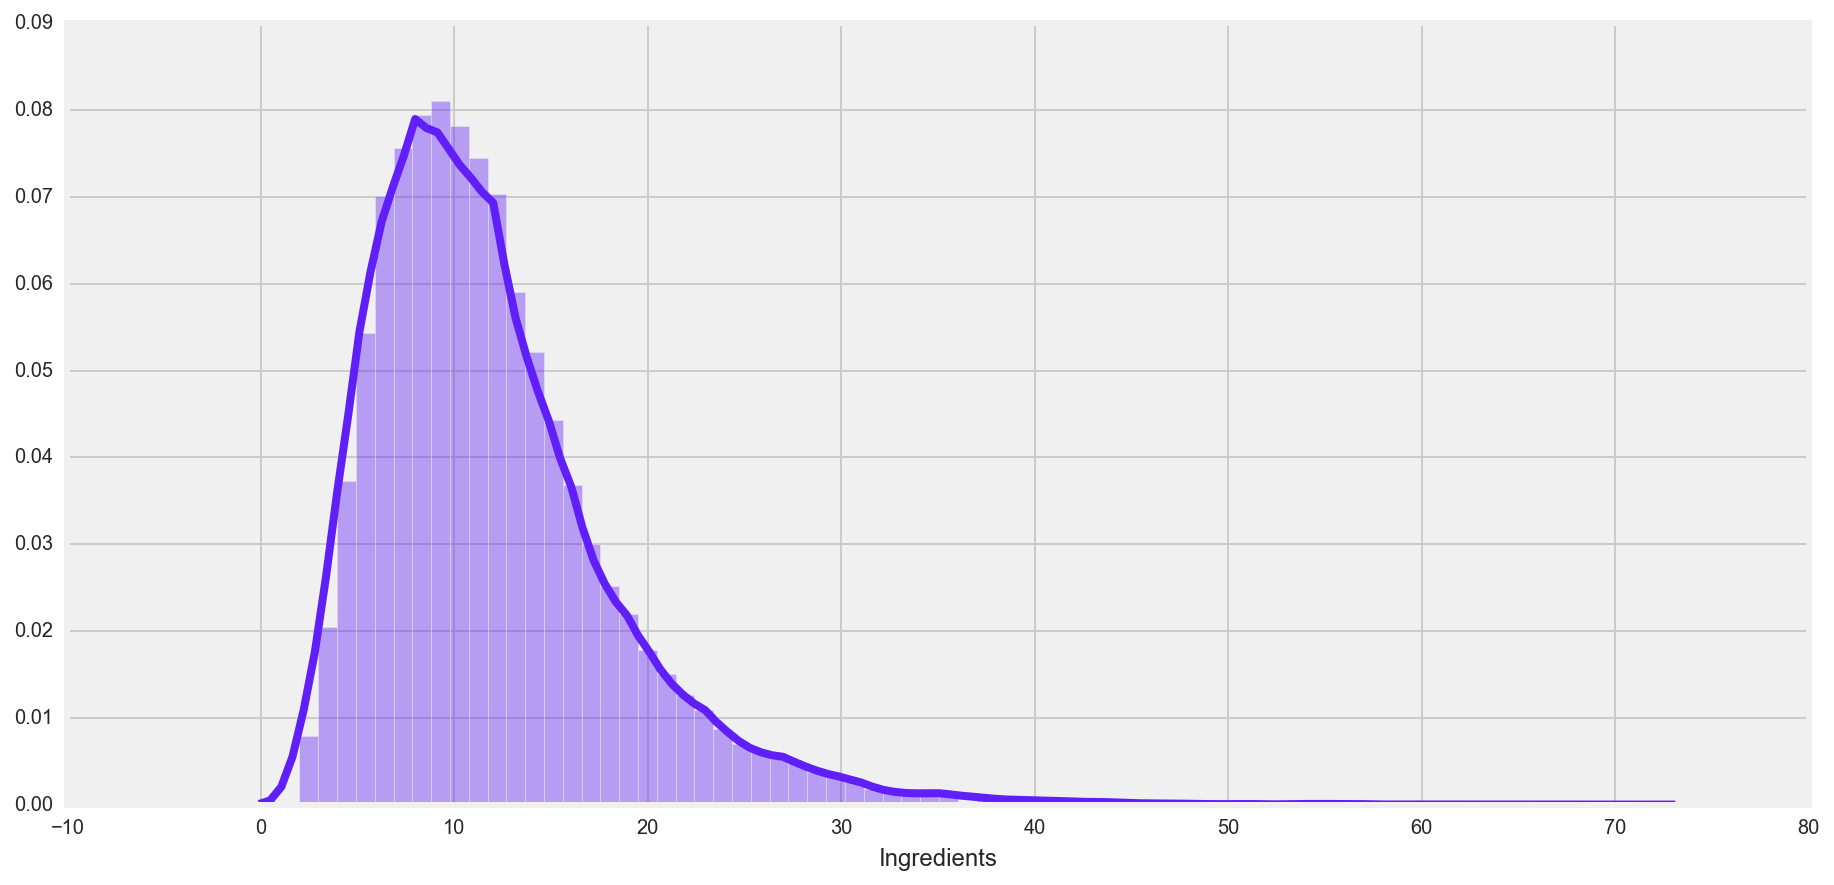

In [284]:
print '\nMode: 9 ingredients - %s recipes' % max(df.ingredients_num.value_counts()), '\n'
print df.ingredients_num.describe(), '\n'
# random color
random = colors[int(len(colors)*np.random.rand())]
fig, ax = plt.subplots(figsize=(13.9,7))
ax = sns.distplot(df.ingredients_num, bins=(df.ingredients_num.max()), hist=True, kde=True, axlabel="Ingredients",
                  color=random)
plt.show()

In [303]:
df[['name','chef','ingredients_num','difficulty','ratings','rating']]\
.sort_values('ingredients_num', ascending=False).head(10)

,name,chef,ingredients_num,difficulty,ratings,rating
41818,REBUILT LOUISIANA SEAFOOD PLATTER,frank brigtsen new orleans louisiana,71.0,Intermediate,0.0,0.0
20286,FRIED CHICKEN,bryan voltaggio,64.0,Intermediate,10.0,4.0
32615,MILK CHOCOLATE PALETTE WITH HONEY CRISP APPLES...,daniel humm,61.0,Advanced,0.0,0.0
24684,GRILLED SOY AND GINGER MARINATED RACK OF LAMB ...,wolfgang puck,60.0,Intermediate,2.0,5.0
41909,RED CURRY MARINATED SKIRT STEAK FAJITAS,bob flay,59.0,Intermediate,27.0,5.0
3132,BARBECUED PULLED PORK SANDWICHES WITH HOMEMADE...,emeril lagasse,57.0,Intermediate,146.0,5.0
29942,LIFE BURGER,life food gourmet,57.0,Intermediate,0.0,0.0
300,AHI PALETTE DANCER,james aptakin and vic vegas,57.0,Advanced,0.0,0.0
35791,OXTAIL AND BLACK BEAN SOUP WITH GRILLED SPINY ...,emeril lagasse,57.0,Intermediate,4.0,5.0
36964,PASTICCIO,mario batali,56.0,Unknown,3.0,5.0


<a id='modeling'></a>
### <a href='#table_of_contents'>back to table of contents</a>
# Modeling - Predict Rating (score) <a id='modeling_contents'></a>
To restate our assessment about the rating system: it is inherently flawed, given that a recipe with 1, 5-star rating has the same score as a recipe with 10, 5-star ratings, and has a better score than a recipe with 100, 4-star ratings. Additionally, the distribution for rating is so heavily favored towards 5-star ratings, that there isn't a proportional difference between each rating tier--in other words, the difference between a 5-star and 4-star rating is more significant than the difference between a 4-star and a 3-star, or a 3-star and a 2-star.  Lastly, 50% of the recipes on foodnetwork.com have 3 ratings or fewer, and a whopping 15,853 (26.94%) have no ratings at all. Our estimation on how best to approach the modeling followed from these assessments. 

Working under the pretext of a flawed rating system, and unreliable, if not incomplete dataset, we decided the best approach for predicting a recipe rating was a supervised, classification method, using recipes with 10 or more ratings as our training set. Because we are most interested in discovering the true or projected rating of the recipes with few or no ratings. 

- <a href='#linreg'>Linear Regression</a>
    - <a href='#ridge'>Ridge</a>
    - <a href='#lasso'>Lasso</a>
    - <a href='#elasticnet'>Elastic Net</a>
- <a href='#kNN'>Logistic Regression, kNN</a>
- <a href='#decision_tree'>Decision Tree Classifier</a>
- <a href='#random_forest'>Random Forest</a>
- <a href='#random_forest_dummy'>Random Forest w/Category Dummy Variables

### Linear Regression (vanilla) <a id='linreg'></a>

In [9]:
# linreg
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score

# normalization
from sklearn.preprocessing import StandardScaler

# patsy
import patsy

In [33]:
X_rating = df[['ratings','time_cook','time_inactive','time_prep','time_total','ingredients_num','difficulty_scale',
               'difficulty_easy','difficulty_intermediate','difficulty_advanced','difficulty_expert',
               'difficulty_unknown','photo_binary','category_1_num','category_2_num','category_3_num',
               'directions_len']]

y_rating = df.rating

In [34]:
formula = '~ ('+' + '.join(X_rating.columns)+')**2 -1'
print formula
X_rating_interactions = patsy.dmatrix(formula, data=X_rating, return_type='dataframe')

~ (ratings + time_cook + time_inactive + time_prep + time_total + ingredients_num + difficulty_scale + difficulty_easy + difficulty_intermediate + difficulty_advanced + difficulty_expert + difficulty_unknown + photo_binary + category_1_num + category_2_num + category_3_num + directions_len)**2 -1


In [35]:
X_rating_interactions.shape

(58852, 153)

In [36]:
ss = StandardScaler()
Xn_rating = ss.fit_transform(X_rating_interactions)

In [37]:
linreg = LinearRegression()

In [38]:
# full dataset normalized
linreg_scores = cross_val_score(linreg, Xn_rating, y_rating, cv=10)

for num, score in enumerate(linreg_scores):
    print 'Fold %s:' % num, score
print '\nAverage Score:', np.mean(linreg_scores)

Fold 0: 0.0816446642965
Fold 1: 0.116013147281
Fold 2: 0.127907433872
Fold 3: 0.101712613509
Fold 4: 0.111903050279
Fold 5: 0.107909190419
Fold 6: 0.104546893074
Fold 7: -0.0178081062829
Fold 8: 0.119595242351
Fold 9: 0.120395287293

Average Score: 0.0973819416092


<a id='ridge'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

### Ridge

In [13]:
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn_rating, y_rating)

print 'Optimal ridge alpha:', optimal_ridge.alpha_

Optimal ridge alpha: 731.680714343


In [14]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn_rating, y_rating, cv=10)

for num, score in enumerate(ridge_scores):
    print 'Fold %s -' % num, score
print '\nAverage Score:', np.mean(ridge_scores)

Fold 0 - 0.0725853069382
Fold 1 - 0.119303237044
Fold 2 - 0.124274929886
Fold 3 - 0.0973113798726
Fold 4 - 0.111841329028
Fold 5 - 0.116755160322
Fold 6 - 0.110278312431
Fold 7 - 0.111990941298
Fold 8 - 0.122827353772
Fold 9 - 0.118034943969

Average Score: 0.110520289456


<a id='lasso'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>
### Lasso 

In [15]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xn_rating, y_rating)

print 'Optimal lasso alpha:', optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal lasso alpha: 0.00318620120261


In [16]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_rating, y_rating, cv=10)

for num, score in enumerate(lasso_scores):
    print 'fold %s -' % num, score
print '\naverage lasso score:', np.mean(lasso_scores)

fold 0 - 0.0627659797089
fold 1 - 0.0817437126018
fold 2 - 0.0880148950191
fold 3 - 0.0506270523566
fold 4 - 0.0770376589273
fold 5 - 0.0832633559459
fold 6 - 0.0909578888986
fold 7 - 0.09795600331
fold 8 - 0.0937778279295
fold 9 - 0.0925163544641

average lasso score: 0.0818660729162


<a id='elasticnet'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>
### Elasticnet 

In [17]:
l1_ratios = np.linspace(0.01, 1.0, 50)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=5, verbose=1)

optimal_enet.fit(Xn_rating, y_rating)

print 'optimal elastic net alpha:', optimal_enet.alpha_
print 'optimal L1 ratio:', optimal_enet.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

optimal elastic net alpha: 0.00235512532953
optimal L1 ratio: 1.0


In [18]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xn_rating, y_rating, cv=10)

for num, score in enumerate(enet_scores):
    print 'fold %s -' % num, score
print '\naverage elastic net score:', np.mean(enet_scores)

fold 0 - 0.0823387092116
fold 1 - 0.117424131104
fold 2 - 0.132040527531
fold 3 - 0.101723697346
fold 4 - 0.115083740491
fold 5 - 0.123454004601
fold 6 - 0.117584881135
fold 7 - 0.139689759528
fold 8 - 0.123116982097
fold 9 - 0.124063634553

average elastic net score: 0.11765200676


<a id='kNN'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

## Logistic Regression, kNN 

Notes for Kiefer on next step:
- with the idea being to use the projected score in the whats_in_the_fridge app, how do I apply the models below on the entire set and assign the projected rating classifications to a new column?
- am I doing what you recommended accurately so far?


In [6]:
# logreg/kNN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

In [7]:
df['rating_classifier'] = df['rating'].map(lambda x: 2 if x == 5 
                                                else 1 if x == 4
                                                else 1 if x == 4.5
                                                else 0)

In [8]:
df['rating_classifier'].value_counts()

0    21431
2    21244
1    16177
Name: rating_classifier, dtype: int64

In [10]:
Xr = df[['ratings','time_cook','time_inactive','time_prep','time_total','ingredients_num','difficulty_scale',
         'difficulty_easy','difficulty_intermediate','difficulty_advanced','difficulty_expert',
         'difficulty_unknown','photo_binary','category_1_num','category_2_num','category_3_num',
         'directions_len']]

Xr_10 = Xr[Xr.ratings >= 10]

yr_10 = df[df.ratings >= 10].rating_classifier

ss = StandardScaler()
nXr_10 = ss.fit_transform(Xr_10)

In [156]:
lr_params = {'penalty':['l1','l2'],
             'solver':['liblinear'],
             'C':np.linspace(0.0001, 1000, 50)
            }

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)

lr_gs.fit(nXr_10, yr_10)
print "Best LogReg Parameters:", lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   16.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   36.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.2min finished


Best LogReg Parameters: {'penalty': 'l1', 'C': 20.408261224489795, 'solver': 'liblinear'}


In [157]:
kNN_params = {'n_neighbors':range(3,10),
              'weights':['uniform','distance']
             }

knn_gs = GridSearchCV(KNeighborsClassifier(), kNN_params, cv=10, verbose=1)

knn_gs.fit(nXr_10, yr_10)

print 'Best kNN Parameters:', knn_gs.best_params_
best_knn = knn_gs.best_estimator_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   35.0s


Best kNN Parameters: {'n_neighbors': 9, 'weights': 'distance'}


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  1.7min finished


In [158]:
nXr_10_tr, nXr_10_te, yr_10_tr, yr_10_te = train_test_split(nXr_10, yr_10, train_size=0.8, stratify=yr_10)
print nXr_10_tr.shape, yr_10_tr.shape
print nXr_10_te.shape, yr_10_te.shape

(13538, 17) (13538,)
(3385, 17) (3385,)


### How our classification models perform on the test set for recipes with 10 or more ratings

In [159]:
model_kNN = best_knn.fit(nXr_10_tr, yr_10_tr)
model_lr = best_lr.fit(nXr_10_tr, yr_10_tr)

predict_kNN = model_kNN.predict(nXr_10_te)
predict_lr = model_lr.predict(nXr_10_te)

kNN_score = model_kNN.score(nXr_10_te, yr_10_te)
lr_score = model_lr.score(nXr_10_te, yr_10_te)

kNN_report = classification_report(yr_10_te, predict_kNN)
lr_report = classification_report(yr_10_te, predict_lr)

print 'kNN Score:', kNN_score
print kNN_report, '\n'
print 'LogReg Score:', lr_score
print lr_report

kNN Score: 0.50694239291
             precision    recall  f1-score   support

          0       0.10      0.02      0.04       218
          1       0.46      0.47      0.46      1433
          2       0.55      0.60      0.58      1734

avg / total       0.48      0.51      0.49      3385


LogReg Score: 0.515805022157
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       218
          1       0.45      0.22      0.29      1433
          2       0.53      0.83      0.65      1734

avg / total       0.46      0.52      0.46      3385



//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### How our classifcation models perform on the recipes with less than 10 ratings

In [164]:
Xr_9 = Xr[Xr.ratings < 10]
yr_9 = df[df.ratings < 10].rating_classifier

nXr_9 = ss.fit_transform(Xr_9)

predict_kNN_9 = model_kNN.predict(nXr_9)
predict_lr_9 = model_lr.predict(nXr_9)

kNN_score = model_kNN.score(nXr_9, yr_9)
lr_score = model_lr.score(nXr_9, yr_9)

kNN_report = classification_report(yr_9, predict_kNN_9)
lr_report = classification_report(yr_9, predict_lr_9)

print 'kNN Score:', kNN_score
print kNN_report, '\n'
print 'LogReg Score:', lr_score
print lr_report

kNN Score: 0.267714469699
             precision    recall  f1-score   support

          0       0.64      0.01      0.02     20339
          1       0.17      0.30      0.22      9013
          2       0.32      0.66      0.43     12577

avg / total       0.44      0.27      0.19     41929


LogReg Score: 0.277564454196
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     20339
          1       0.06      0.09      0.07      9013
          2       0.38      0.86      0.53     12577

avg / total       0.13      0.28      0.17     41929



### Assigning a projected clasifier score for each recipe

In [ ]:
# df['rating_logreg_predict'] = model_lr.predict(Xr)
# df['rating_kNN_predict'] = model_kNN.predict(Xr)

<a id='decision_tree'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

## Decision Tree Classifier 

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [11]:
Xr_10_tr, Xr_10_te, yr_10_tr, yr_10_te = train_test_split(Xr_10, yr_10, train_size=0.8, stratify=yr_10)
print Xr_10_tr.shape, yr_10_tr.shape
print Xr_10_te.shape, yr_10_te.shape

(13538, 17) (13538,)
(3385, 17) (3385,)


In [13]:
dtc1 = DecisionTreeClassifier(max_depth=1)
dtc2 = DecisionTreeClassifier(max_depth=2)
dtc3 = DecisionTreeClassifier(max_depth=3)

In [14]:
dtc1.fit(Xr_10_tr, yr_10_tr)
dtc2.fit(Xr_10_tr, yr_10_tr)
dtc3.fit(Xr_10_tr, yr_10_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [18]:
dtc1_scores = cross_val_score(dtc1, Xr_10_tr, yr_10_tr, cv=5)
dtc2_scores = cross_val_score(dtc2, Xr_10_tr, yr_10_tr, cv=5)
dtc3_scores = cross_val_score(dtc3, Xr_10_tr, yr_10_tr, cv=5)

print 'Decision Tree 1:\n', 'Scores:', dtc1_scores, '\nAverage Score:', np.mean(dtc1_scores), '\n'
print 'Decision Tree 2:\n', 'Scores:', dtc2_scores, '\nAverage Score:', np.mean(dtc2_scores), '\n'
print 'Decision Tree 3:\n', 'Scores:', dtc3_scores, '\nAverage Score:', np.mean(dtc3_scores), '\n'

Decision Tree 1:
Scores: [ 0.51199705  0.51218612  0.51218612  0.51200591  0.51219512] 
Average Score: 0.512114061972 

Decision Tree 2:
Scores: [ 0.52713178  0.5310192   0.5217873   0.52604359  0.51404287] 
Average Score: 0.52400494812 

Decision Tree 3:
Scores: [ 0.53156146  0.52880355  0.52806499  0.52678242  0.52808574] 
Average Score: 0.528659630164 



In [21]:
# initiate decision tree classifier
dctc = DecisionTreeClassifier()

## Search parameters
dtc_params = {'max_depth':[None,1,2,3,4],
              'max_features':[None,'log2','sqrt','auto', 2,3,4,5],
              'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
             }

## Gridsearch    
dtc_gs = GridSearchCV(dctc, dtc_params, n_jobs=-1, cv=5, verbose=1)

## fit
dtc_gs.fit(Xr_10_tr, yr_10_tr)

Fitting 5 folds for each of 440 candidates, totalling 2200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed:   21.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 'auto', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [22]:
## Print best estimator, best parameters, and best score
dtc_best_estimator = dtc_gs.best_estimator_
print "best estimator\n", dtc_best_estimator

print "\n=========="
dct_best_param = dtc_gs.best_params_
print "best parameters\n",  dct_best_param 

print "\n=========="
print "best score\n", dtc_gs.best_score_


best estimator
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

best parameters
{'max_features': None, 'min_samples_split': 2, 'max_depth': 4}

best score
0.534347761856


In [23]:
## Predict
yr_10_pred= dtc_gs.predict(Xr_10_te)
print yr_10_pred.shape, yr_10_te.shape

(3385,) (3385,)


In [25]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

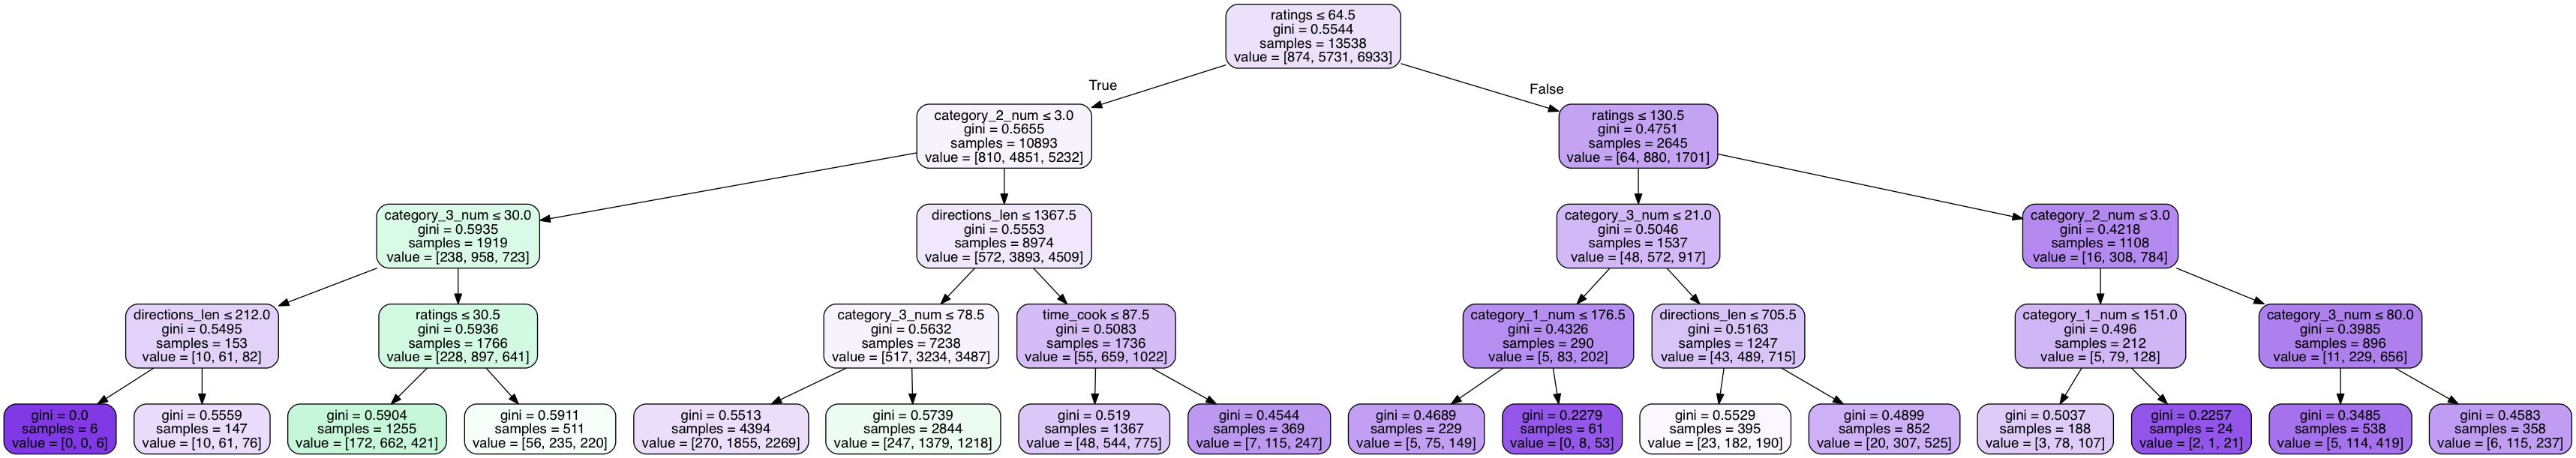

In [26]:
dot_data = StringIO()

## Define decision tree with best parameters, you can also use the best estimators
dctc_best= DecisionTreeClassifier(max_features= None, min_samples_split= 25, max_depth= 4)
                                    

## Fit the best estimators (X_train, y_train)
dctc_best.fit(Xr_10_tr, yr_10_tr)


## Graph
export_graphviz(dctc_best, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xr.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [27]:
## Print Feature importances
feature_importance = pd.DataFrame({'feature':Xr.columns, 
                                   'importance':dctc_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,feature,importance
0,ratings,0.450153
14,category_2_num,0.178251
15,category_3_num,0.165252
16,directions_len,0.145726
13,category_1_num,0.038530
1,time_cook,0.022088
4,time_total,0.000000
5,ingredients_num,0.000000
6,difficulty_scale,0.000000
7,difficulty_easy,0.000000


In [30]:
## Print a classification report
cls_rep = classification_report(yr_10_te, yr_10_pred)
print cls_rep 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       218
          1       0.47      0.37      0.41      1433
          2       0.55      0.72      0.63      1734

avg / total       0.48      0.52      0.50      3385



//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<a id='random_forest'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

## Random Forest 

In [11]:
from sklearn.ensemble import RandomForestClassifier

rfc1 = RandomForestClassifier(max_depth=1, n_estimators=10, random_state=1, n_jobs=1) 
rfc2 = RandomForestClassifier(max_depth=2,  n_estimators=10, random_state=1, n_jobs=1)
rfc3 = RandomForestClassifier(max_depth=3,  n_estimators=10, random_state=1, n_jobs=1)

In [44]:
## Fit the models
rfc1.fit(Xr_10_tr, yr_10_tr)
rfc2.fit(Xr_10_tr, yr_10_tr)
rfc3.fit(Xr_10_tr, yr_10_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [45]:
rfc1_scores = cross_val_score(rfc_1, Xr_10_tr, yr_10_tr, cv=5)
rfc2_scores = cross_val_score(rfc_2, Xr_10_tr, yr_10_tr, cv=5)
rfc3_scores = cross_val_score(rfc_3, Xr_10_tr, yr_10_tr, cv=5)

print 'Random Forest 1:\n', 'Scores:', rfc1_scores, '\nAverage Score:', np.mean(rfc1_scores), '\n'
print 'Random Forest 2:\n', 'Scores:', rfc2_scores, '\nAverage Score:', np.mean(rfc2_scores), '\n'
print 'Random Forest 3:\n', 'Scores:', rfc3_scores, '\nAverage Score:', np.mean(rfc3_scores), '\n'

Random Forest 1:
Scores: [ 0.51199705  0.51218612  0.51218612  0.51200591  0.51219512] 
Average Score: 0.512114061972 

Random Forest 2:
Scores: [ 0.51458103  0.51809453  0.51698671  0.51939416  0.51182557] 
Average Score: 0.516176400612 

Random Forest 3:
Scores: [ 0.52750092  0.52658789  0.52584934  0.53454008  0.53399852] 
Average Score: 0.529695349793 



In [47]:
## Define a Random Forest Classifier
rfc = RandomForestClassifier()

rf_params = {'max_features':[None,'log2','sqrt', 2,3,4,5],
             'max_depth':[1,2,3,None],
             'min_samples_leaf':np.linspace(1,101,20),
             'n_estimators':[100]
            }

## gridsearch parameters, and cv =5
rf_gs = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)

# fit
rf_gs.fit(Xr_10_tr, yr_10_tr)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 12.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'n_estimators': [100], 'max_depth': [1, 2, 3, None], 'min_samples_leaf': array([   1.     ,    6.26316,   11.52632,   16.78947,   22.05263,
         27.31579,   32.57895,   37.84211,   43.10526,   48.36842,
         53.63158,   58.89474,   64.15789,   69.42105,   74.68421,
         79.94737,   85.21053,   90.47368,   95.73684,  101.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [48]:
## Print best estimator, best parameters, and best score
rfc_best = rf_gs.best_estimator_
print "best estimator\n", rfc_best
print "\n=========="
print "best parameters\n", rf_gs.best_params_
print "\n=========="
print "best score\n", rf_gs.best_score_

best estimator
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=64.15789473684211, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters
{'max_features': None, 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 64.15789473684211}

best score
0.549933520461


In [49]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':Xr.columns, 
                                   'importance':rfc_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,feature,importance
0,ratings,0.226568
15,category_3_num,0.157449
16,directions_len,0.141292
13,category_1_num,0.098934
14,category_2_num,0.098818
5,ingredients_num,0.077609
4,time_total,0.073738
1,time_cook,0.067870
3,time_prep,0.024805
2,time_inactive,0.016008


In [51]:
## Predict 
yr_10_pred_rfc= rfc_best.predict(Xr_10_te)
print yr_10_pred_rfc.shape, yr_10_te.shape

 (3385,) (3385,)


In [52]:
## Print classification report
cls_rep = classification_report(yr_10_te, yr_10_pred_rfc)
print cls_rep 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       218
          1       0.49      0.38      0.43      1433
          2       0.56      0.74      0.64      1734

avg / total       0.50      0.54      0.51      3385



<a id='random_forest_dummy'></a>
### <a href='#modeling_contents'>back to modeling table of contents</a>

## Random Forest with dummy variables for categories

In [16]:
categories = pd.read_csv('../data_clean/categories.csv')
categories['category'] = categories['0'].map(lambda x: x.lower() if x else '')

In [17]:
categories.head()

,Unnamed: 0,index,0,category
0,0,1,Bourbon,bourbon
1,1,2,Dessert,dessert
2,2,3,Apple,apple
3,3,4,Side Dish,side dish
4,4,5,Sauce,sauce


In [18]:
df_ = df
df_.shape

(58852, 31)

In [19]:
for value in categories.category:
    df_[value] = ''

In [20]:
df_.shape

(58852, 455)

In [21]:
for col in df_.columns[31:]:
    df_[col] = df_['category_1'].map(lambda x: 1 if x == col else 0)
    df_[col][df_[col] != 1] = df_['category_2'].map(lambda x: 1 if x == col else 0)
    df_[col][df_[col] != 1] = df_['category_3'].map(lambda x: 1 if x == col else 0)

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
df_['easy'].value_counts()

0    53856
1     4996
Name: easy, dtype: int64

In [23]:
df_.columns[31:]

Index([u'bourbon', u'dessert', u'apple', u'side dish', u'sauce', u'fruit',
       u'easy', u'whole wheat', u'pizza dough', u'heart healthy',
       ...
       u'honeydew', u'rosh hashanah', u'millet', u'lebanese', u'low fat',
       u'labor day', u'low carbohydrate', u'venezuelan', u'eel', u'turkish'],
      dtype='object', length=424)

In [52]:
df_.columns[:31]

Index([u'categories', u'chef', u'difficulty', u'directions', u'ingredients',
       u'name', u'photo', u'rating', u'ratings', u'time_cook',
       u'time_inactive', u'time_prep', u'time_total', u'url', u'yield_',
       u'ingredients_num', u'difficulty_scale', u'difficulty_easy',
       u'difficulty_intermediate', u'difficulty_advanced',
       u'difficulty_expert', u'difficulty_unknown', u'photo_binary',
       u'category_1', u'category_2', u'category_3', u'category_1_num',
       u'category_2_num', u'category_3_num', u'directions_len',
       u'rating_classifier'],
      dtype='object')

In [53]:
df_.shape

(58852, 455)

In [55]:
Xr = df_[[col for col in df.columns if col not in ['categories','chef','difficulty','directions','ingredients',
                                                    'name','photo','url','yield_','category_1','category_2',
                                                    'category_3','rating','rating_classifier','category_1_num',
                                                    'category_2_num','category_3_num']]]
yr = df_.rating_classifier

In [56]:
Xr_ = Xr
yr_ = yr

In [57]:
print Xr_.shape, yr_.shape

(58852, 438) (58852,)


In [58]:
Xr_ = Xr_[Xr_.ratings >= 10]
yr_ = df_[df_.ratings >= 10].rating_classifier

In [59]:
print Xr_.shape, yr_.shape

(16923, 438) (16923,)


In [37]:
trainXr_, testXr_, trainyr_, testyr_ = train_test_split(Xr_, yr_, train_size=0.8, stratify=yr_)
print trainXr_.shape, trainyr_.shape
print testXr_.shape, testyr_.shape

(13538, 438) (13538,)
(3385, 438) (3385,)


In [38]:
## Define a Random Forest Classifier
rfc = RandomForestClassifier()

rf_params = {'max_features':[None,'log2','sqrt', 2,3,4,5],
             'max_depth':[1,2,3,None],
             'min_samples_leaf':np.linspace(1,101,20),
             'n_estimators':[100]
            }

## gridsearch parameters, and cv =5
rf_gs = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)

# fit
rf_gs.fit(trainXr_, trainyr_)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 29.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'n_estimators': [100], 'max_depth': [1, 2, 3, None], 'min_samples_leaf': array([   1.     ,    6.26316,   11.52632,   16.78947,   22.05263,
         27.31579,   32.57895,   37.84211,   43.10526,   48.36842,
         53.63158,   58.89474,   64.15789,   69.42105,   74.68421,
         79.94737,   85.21053,   90.47368,   95.73684,  101.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [40]:
## Print best estimator, best parameters, and best score
rfc_best = rf_gs.best_estimator_
print "best estimator\n", rfc_best
print "\n=========="
print "best parameters\n", rf_gs.best_params_
print "\n=========="
print "best score\n", rf_gs.best_score_

best estimator
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1.0, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters
{'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1.0}

best score
0.553922292805


In [42]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':Xr_.columns, 
                                   'importance':rfc_best.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(15)

,feature,importance
13,directions_len,0.094441
0,ratings,0.093659
4,time_total,0.073921
5,ingredients_num,0.072029
1,time_cook,0.066923
3,time_prep,0.054000
2,time_inactive,0.032839
12,photo_binary,0.015682
6,difficulty_scale,0.011467
32,dinner,0.009932


### Apply random forest model to test set

In [43]:
## Predict 
predictions_testyr_ = rfc_best.predict(testXr_)
print predictions_testyr_.shape, testyr_.shape

(3385,) (3385,)


In [44]:
## Print classification report
cls_rep = classification_report(testyr_, predictions_testyr_)
print cls_rep 

             precision    recall  f1-score   support

          0       0.33      0.01      0.02       218
          1       0.51      0.44      0.47      1433
          2       0.58      0.71      0.64      1734

avg / total       0.53      0.55      0.53      3385



### Apply Random Forest model to dataset save results as a new variable in the recipes dataset and save dataset as a new .csv we can use in our whats_in_the_fridge app

In [62]:
model_rfc = rfc_best.fit(Xr_, yr_)
df_['rating_rfc_predict'] = model_rfc.predict(Xr)

In [69]:
## Predict / Classification report
predictions_full = model_rfc.predict(Xr)

## Print classification report
cls_rep = classification_report(yr, predictions_full)
print cls_rep 

             precision    recall  f1-score   support

          0       0.95      0.05      0.10     21431
          1       0.44      0.70      0.54     16177
          2       0.50      0.75      0.60     21244

avg / total       0.65      0.48      0.40     58852



In [63]:
df_['rating_rfc_predict'].value_counts()

2    31763
1    25881
0     1208
Name: rating_rfc_predict, dtype: int64

In [66]:
df_['rating_rfc_predict_rating'] = df_['rating_rfc_predict'].map(lambda x: 5. if x == 2
                                                                      else 4. if x == 1
                                                                      else 3.)

In [67]:
df_['rating_rfc_predict_rating'].value_counts()

5.0    31763
4.0    25881
3.0     1208
Name: rating_rfc_predict_rating, dtype: int64

In [68]:
df_[['categories','chef','difficulty','directions','ingredients','name','rating','ratings','time_cook',
     'time_inactive','time_prep','time_total','url','yield_','ingredients_num','difficulty_scale',
     'category_1','category_2','category_3','rating_rfc_predict',
     'rating_rfc_predict_rating']].to_csv('../data_clean/recipes_cleanest_w_model_predict.csv')